<a href="https://colab.research.google.com/github/yeowonh/2021_summer/blob/main/Dacon_%EC%8B%9D%EC%88%98%EC%9D%B8%EC%9B%90%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구내식당 식수 인원 예측 AI 경진대회

* 평가방식 : MAE
* 외부 데이터 허용

<참고 코드를 통한 인사이트>


* 국, 반찬 모두 sparse한 경향 보임 -> 인코딩 방법

* 김치/사이드 분리기준 명확하지 않음

  => 큰 영향 미치지 않는다면 배제

* 저녁 target 0명인 날(문화의 날, 연휴) 처리

* 코로나에 의한 인원 감소는 없음

* train-test data 어느 기간, 비율로 나눌지 생각

  최근의 경향성을 나타내는 20~21년도 데이터 test data로

* target_ln과 target_dn 사이의 correlation이 큼 -> 이 부분을 해결할 방법 필요

* target 값이 여러개: deep learning 이용해보기

## 라이브러리 & 데이터 불러오기 (*)

In [ ]:
# 드라이브 마운트
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/LH/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/LH/test.csv")
submission = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/LH/sample_submission.csv")

## column 영문 변환 (*)

In [ ]:
train.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn', 'target_ln', 'target_dn']

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,target_ln,target_dn
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [ ]:
test.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn']
test.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


## datetime 변환 (*)

In [ ]:
def to_datetime(df, date):
    df['date'] = pd.to_datetime(df[date])
    df['dow'] = pd.to_datetime(df[date]).dt.weekday + 1

In [ ]:
def menu_to_list(data, flag):
  list_menu = []
  for day in range(len(data)):
    if flag == 'lunch':
      tmp = data.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    else:
      tmp = data.iloc[day, 9].split(' ')
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보는 삭제

    for idx, menu in enumerate(tmp):
      if menu[0:5] == "(NEW)" or menu[0:5] == "(New)":
        tmp[idx] = tmp[idx][5:]
      elif search in menu:
          tmp.remove(menu)
    
    list_menu.append(tmp) 
  return list_menu

In [ ]:
to_datetime(train, 'date')
to_datetime(test, 'date')

train_lunch = []
test_lunch = []
train_dinner = []
test_dinner = []

In [ ]:
train_lunch = menu_to_list(train, 'lunch')
test_lunch = menu_to_list(test, 'lunch')

train_dinner = menu_to_list(train[train['target_dn']!=0.0], 'dinner')
test_dinner = menu_to_list(test, 'dinner')

7/1 부터 순서가 바뀜

2020-06-13 ~ 2020-06-30 데이터 누락

#시계열 인원 살펴보기

## 계절 변수 

In [ ]:
season=[]
# 봄(3~5):1, 여름(6~8):2, 가을(9~10):3, 겨울(11~12,1~2):4
for i in range(train.shape[0]):
    if train['date'][i].month in [3,4,5]:
        season.append(1)
    elif train['date'][i].month in [6,7,8]:
        season.append(2)
    elif train['date'][i].month in [9,10]:
        season.append(3)
    elif train['date'][i].month in [11,12]:
        season.append(4)
    elif train['date'][i].month in [1,2]:
        season.append(4)  


train['season'] = season
print(train.iloc[150:160,:])

In [ ]:
season2=[]
# 봄(3~5):1, 여름(6~8):2, 가을(9~10):3, 겨울(11~12,1~2):4
for i in range(test.shape[0]):
    if test['date'][i].month in [3,4,5]:
        season2.append(1)
    elif test['date'][i].month in [6,7,8]:
        season2.append(2)
    elif test['date'][i].month in [9,10]:
        season2.append(3)
    elif test['date'][i].month in [11,12]:
        season2.append(4)
    elif test['date'][i].month in [1,2]:
        season2.append(4)  


test['season'] = season2
print(test.iloc[150:160,:])

## 휴일의 전날, 휴일의 다음날

In [ ]:
holi_bef = []
holi_aft = [0]
for i in range(0, train.shape[0]-1):

    if train['dow'][i+1] == train['dow'][i]+1:
        holi_bef.append(0)
    else:
        holi_bef.append(1)
    
    if train['dow'][i] == train['dow'][i+1]-1:
        holi_aft.append(0)
    else:
        holi_aft.append(1)


holi_bef.append(0)
print(len(holi_bef), len(holi_aft))


In [ ]:
train['holi_bef'] = holi_bef
train['holi_aft'] = holi_aft
train.head(10)

In [ ]:
holi_bef = []
holi_aft = [0]
for i in range(0, test.shape[0]-1):

    if test['dow'][i+1] == test['dow'][i]+1:
        holi_bef.append(0)
    else:
        holi_bef.append(1)
    
    if test['dow'][i] == test['dow'][i+1]-1:
        holi_aft.append(0)
    else:
        holi_aft.append(1)


holi_bef.append(1)
print(len(holi_bef), len(holi_aft))


In [ ]:
test['holi_bef'] = holi_bef
test['holi_aft'] = holi_aft
test.head(10)

# 날씨 데이터 생성

In [ ]:
weather = pd.read_csv('weather.csv')
weather.head()

In [ ]:
to_datetime(weather,'date')
weather.head()

In [ ]:
train= pd.merge(train, weather.iloc[:, 1:-1], on='date', how='inner')
train.info()

In [ ]:
test= pd.merge(test, weather.iloc[:, 1:-1], on='date', how='inner')
test.info()

In [ ]:
train.head()

In [ ]:
test.head()

# 메뉴별 데이터프레임 생성 (*)

메뉴명을 추출해 데이터프레임 적용

#### train data 가공

In [ ]:
# lunch train data에 메뉴명별 칼럼 만들기 (밥, 국, 반찬1-3)
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; else_thing=[]

for i, day_menu in enumerate(train_lunch):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)
    else_tmp = day_menu[5:]; else_thing.append(else_tmp)

In [ ]:
train_ln = train[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'ln', 'target_ln']]
train_ln['bob'] = bob
train_ln['gook'] = gook
train_ln['banchan1'] = banchan1; train_ln['banchan2'] = banchan2; train_ln['banchan3'] = banchan3
train_ln['else'] = else_thing
train_ln['ln_rate'] = train_ln['target_ln']/(train_ln['employees'] - train_ln['dayoff'] - train_ln['bustrip'] - train_ln['remote'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# dinner train data에 메뉴명별 칼럼 만들기 (밥, 국, 반찬1-3)
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; else_thing=[]
bob_tmp = []; gook_tmp=[]; banchan1_tmp=[]; banchan2_tmp=[]; banchan3_tmp=[]
exception_list = ['*', '자기계발의날', '*자기계발의날*', '가정의날', '자기개발의날', '＜자기', '계발의', '날＞']

for i, day_menu in enumerate(train_dinner):
    if day_menu[0] in exception_list:
      bob.append('*'); gook.append('*'); banchan1.append('*'); banchan2.append('*'); banchan3.append('*'); else_thing.append('*')

    elif i == 1141:
      bob.append('*')
      gook.append(day_menu[0])
      banchan1.append(day_menu[1])
      banchan2.append(day_menu[2])
      banchan3.append('*')
      else_thing.append(day_menu[3])

    else:
      bob_tmp = day_menu[0]; bob.append(bob_tmp)
      gook_tmp = day_menu[1]; gook.append(gook_tmp)
      banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
      banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
      banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)
      else_tmp = day_menu[5:]; else_thing.append(else_tmp)

In [ ]:
train_tmp = train[train['target_dn']!=0.0].reset_index(drop=True)
train_dn = train_tmp[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'dn', 'target_dn']]
train_dn['bob'] = bob
train_dn['gook'] = gook
train_dn['banchan1'] = banchan1; train_dn['banchan2'] = banchan2; train_dn['banchan3'] = banchan3
train_dn['else'] = else_thing
train_dn['dn_rate'] = train_dn['target_dn']/(train_dn['employees'] - train_dn['dayoff'] - train_dn['bustrip'] - train_dn['remote'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### test data 가공

In [ ]:
# lunch test data에 메뉴명별 칼럼 만들기 (밥, 국, 반찬1-3)
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; else_thing=[]

for i, day_menu in enumerate(test_lunch):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)
    else_tmp = day_menu[5:]; else_thing.append(else_tmp)

In [ ]:
test_ln = test[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'ln']]
test_ln['bob'] = bob
test_ln['gook'] = gook
test_ln['banchan1'] = banchan1; test_ln['banchan2'] = banchan2; test_ln['banchan3'] = banchan3
test_ln['else'] = else_thing
test_ln.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,bob,gook,banchan1,banchan2,banchan3,else
0,2021-01-27,3,2983,88,182,5,358.0,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,"[포기김치, 양상추샐러드*딸기D]"
1,2021-01-28,4,2983,104,212,409,348.0,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,"[겉절이김치, 양상추샐러드*오미자D]"
2,2021-01-29,5,2983,270,249,0,294.0,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,"[포기김치, 양상추샐러드*파인요거트D]"
3,2021-02-01,1,2924,108,154,538,322.0,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,"[포기김치, 양상추샐러드*망고D]"
4,2021-02-02,2,2924,62,186,455,314.0,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,"[알타리김치/사과푸딩, 양상추샐러드*오리엔탈D]"


In [ ]:
# dinner test data에 메뉴명별 칼럼 만들기 (밥, 국, 반찬1-3)
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; else_thing=[]

for i, day_menu in enumerate(test_dinner):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)
    else_tmp = day_menu[5:]; else_thing.append(else_tmp)

In [ ]:
test_dn = test[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'dn']]
test_dn['bob'] = bob
test_dn['gook'] = gook
test_dn['banchan1'] = banchan1; test_dn['banchan2'] = banchan2; test_dn['banchan3'] = banchan3
test_dn['else'] = else_thing
test_dn.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,bob,gook,banchan1,banchan2,banchan3,else
0,2021-01-27,3,2983,88,182,5,358.0,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,아삭이고추무절임,[포기김치]
1,2021-01-28,4,2983,104,212,409,348.0,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,충무김밥,우동국물,오징어무침,꽃맛살샐러드,얼갈이쌈장무침,[석박지]
2,2021-01-29,5,2983,270,249,0,294.0,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,흑미밥,물만둣국,카레찜닭,숯불양념꼬지어묵,꼬시래기무침,[포기김치]
3,2021-02-01,1,2924,108,154,538,322.0,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,흑미밥,동태탕,돈육꽈리고추장조림,당면채소무침,모자반무침,[포기김치]
4,2021-02-02,2,2924,62,186,455,314.0,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,흑미밥,바지락살국,쇠고기청경채볶음,두부구이*볶은김치,머위된장무침,[백김치]


#### 식단 rate 높은 상위 15개 날

In [ ]:
ln_sorted = train_ln.sort_values(by='ln_rate', ascending=False)
ln_sorted.head(15)

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,else,ln_rate
1170,2020-12-01,2,2990,204,161,878,408.0,쌀밥/찰보리밥/찰현미밥 김치두부국 LA갈비구이 한식잡채 삼색유자청무침 포기김치/오프...,1324.0,쌀밥/찰보리밥/찰현미밥,김치두부국,LA갈비구이,한식잡채,삼색유자청무침,"[포기김치/오프룻요거트, 펜네파스타샐러드/축하떡]",0.597203
490,2018-01-29,1,2655,70,192,454,0.0,쌀밥/잡곡밥 (쌀:국내산) 봄동된장국 가래떡돼지갈비찜 콩나물겨자채 참나물무침 ...,1417.0,쌀밥/잡곡밥,봄동된장국,가래떡돼지갈비찜,콩나물겨자채,참나물무침,[포기김치],0.592144
1174,2020-12-07,1,2990,211,185,941,339.0,쌀밥/흑미밥/찰현미밥 유부주머니국 삼겹살김치볶음 두부구이 어묵간장조림 포기김치/귤 ...,1317.0,쌀밥/흑미밥/찰현미밥,유부주머니국,삼겹살김치볶음,두부구이,어묵간장조림,"[포기김치/귤, 양상추샐러드*오미지D]",0.584035
1179,2020-12-14,1,2990,221,142,892,336.0,쌀밥/흑미밥/찰현미밥 (New)누룽지장각백숙 (New)캔꽁치튀김 쫄면채소무침 풋고추...,1329.0,쌀밥/흑미밥/찰현미밥,누룽지장각백숙,캔꽁치튀김,쫄면채소무침,풋고추양파쌈장무침,"[석박지/청포도주스, 양상추샐러드*키위요거트D]",0.580096
398,2017-09-11,1,2642,101,203,478,0.0,쌀밥/잡곡밥 (쌀:국내산) 시래기된장국 유자청제육볶음 오꼬노미야끼계란말이 치커...,1350.0,쌀밥/잡곡밥,시래기된장국,유자청제육볶음,오꼬노미야끼계란말이,치커리무침,[포기김치],0.577417
255,2017-02-13,1,2632,61,196,505,0.0,쌀밥/잡곡밥 (쌀:국내산) 쇠고기미역국 제육볶음 두부구이*양념장 도라지오이생채...,1364.0,쌀밥/잡곡밥,쇠고기미역국,제육볶음,두부구이*양념장,도라지오이생채,[포기김치],0.574316
1188,2021-01-04,1,2983,92,91,490,340.0,쌀밥/흑미밥/찰현미밥 소고기떡국 봉추찜닭 오미산적/동태전 콩나물잡채 포기김치/식혜 ...,1405.0,쌀밥/흑미밥/찰현미밥,소고기떡국,봉추찜닭,오미산적/동태전,콩나물잡채,"[포기김치/식혜, 양상추샐러드*요거트감귤D]",0.571138
1109,2020-08-31,1,2989,183,163,648,464.0,쌀밥/흑미밥/찰현미밥 황태콩나물해장국 (New)궁보계정 시금치프리타타 가지고추장무침...,1243.0,쌀밥/흑미밥/찰현미밥,황태콩나물해장국,궁보계정,시금치프리타타,가지고추장무침,"[포기김치/요구르트, 양상추샐러드*석류D]",0.570445
503,2018-02-19,1,2707,255,171,604,0.0,쌀밥/잡곡밥 (쌀:국내산) 들깨미역국 훈제오리구이 두부양념조림 쌈무/부추생채 ...,1298.0,쌀밥/잡곡밥,들깨미역국,훈제오리구이,두부양념조림,쌈무/부추생채,[포기김치],0.569049
279,2017-03-20,1,2627,86,207,390,0.0,쌀밥/잡곡밥 (쌀:국내산) 아욱국 콩나물불고기 맛살전 상추무침 포기김치 (김...,1328.0,쌀밥/잡곡밥,아욱국,콩나물불고기,맛살전,상추무침,[포기김치],0.568980


dow == 1 일때가 상위 대부분을 차지함.

dow와의 연관성을 최대한 배제하기 위해 dow != 1일때의 식단을 살펴보자

In [ ]:
ln_sorted = train_ln[train_ln['dow']!=1].sort_values(by='ln_rate', ascending=False)
ln_sorted.head(15)

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,else,ln_rate
1170,2020-12-01,2,2990,204,161,878,408.0,쌀밥/찰보리밥/찰현미밥 김치두부국 LA갈비구이 한식잡채 삼색유자청무침 포기김치/오프...,1324.0,쌀밥/찰보리밥/찰현미밥,김치두부국,LA갈비구이,한식잡채,삼색유자청무침,"[포기김치/오프룻요거트, 펜네파스타샐러드/축하떡]",0.597203
164,2016-10-05,3,2670,41,228,0,0.0,쌀밥/잡곡밥 (쌀:국내산) 차돌박이찌개 (쇠고기:호주산) 매운주꾸미볶음 모둠소세지...,1336.0,쌀밥/잡곡밥,차돌박이찌개,매운주꾸미볶음,모둠소세지구이,콩나물무침,[포기김치],0.556435
1180,2020-12-15,2,2990,203,179,814,400.0,쌀밥/차조밥/찰현미밥 굴떡국 콩나물파채불고기 쌈배추/양상추*쌈장 건취나물볶음 포기김...,1202.0,쌀밥/차조밥/찰현미밥,굴떡국,콩나물파채불고기,쌈배추/양상추*쌈장,건취나물볶음,"[포기김치, 과일샐러드]",0.544384
413,2017-10-10,2,2645,105,209,641,0.0,쌀밥/잡곡밥 (쌀:국내산) 아욱국 훈제오리구이 계란찜 쌈무/부추생채 포기김치...,1265.0,쌀밥/잡곡밥,아욱국,훈제오리구이,계란찜,쌈무/부추생채,[포기김치],0.542686
1171,2020-12-02,3,2990,223,157,5,398.0,(New)바지락비빔밥 (쌀밥/찰현미밥) 팽이장국 메밀전병 채소프리타타 산고추지무침/...,1188.0,바지락비빔밥,팽이장국,메밀전병,채소프리타타,산고추지무침/겉절이김치,[양상추샐러드*매실D],0.537071
83,2016-06-07,2,2637,115,192,389,0.0,쌀밥/잡곡밥 (쌀:국내산) 북어계란국 돈육굴소스볶음 홍어채무침 가지나물 포기...,1244.0,쌀밥/잡곡밥,북어계란국,돈육굴소스볶음,홍어채무침,가지나물,[포기김치],0.533906
163,2016-10-04,2,2670,59,239,1035,0.0,쌀밥/잡곡밥 (쌀:국내산) 배추된장국 버섯불고기 (쇠고기:호주산) 골뱅이소면무침 ...,1262.0,쌀밥/잡곡밥,배추된장국,버섯불고기,골뱅이소면무침,마늘쫑건새우볶음,[포기김치],0.532040
652,2018-10-10,3,2805,80,232,1044,0.0,곤드레밥*강된장 (쌀:국내산) 맑은국 돈육강정 사과고구마그라탱 오이초무침 포...,1319.0,곤드레밥*강된장,맑은국,돈육강정,사과고구마그라탱,오이초무침,[포기김치],0.529081
247,2017-02-01,3,2632,61,179,0,0.0,쌀밥/잡곡밥 (쌀:국내산) 시금치된장국 고추장불고기 닭살겨자채 모듬쌈 포기김...,1260.0,쌀밥/잡곡밥,시금치된장국,고추장불고기,닭살겨자채,모듬쌈,[포기김치],0.526756
312,2017-05-10,3,2637,68,223,0,0.0,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 제육볶음 잡채 콩나물무침 포기김치 (김치...,1235.0,쌀밥/잡곡밥,된장찌개,제육볶음,잡채,콩나물무침,[포기김치],0.526428


역시나 dow와 높은 관련성 보임.


In [ ]:
dn_sorted = train_dn.sort_values(by='dn_rate', ascending=False)
dn_sorted.head(15)

,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,target_dn,bob,gook,banchan1,banchan2,banchan3,else,dn_rate
163,2016-10-04,2,2670,59,239,1035,0.0,쌀밥/잡곡밥 (쌀:국내산) 콩비지찌개 (돼지고기:국내산) 닭볶음 (닭고기:국내산) ...,902.0,쌀밥/잡곡밥,콩비지찌개,닭볶음,해파리냉채,상추치커리무침,[포기김치],0.380270
164,2016-10-05,3,2670,41,228,0,0.0,"쌀밥/잡곡밥 (쌀:국내산) 순두부찌개 미니함박조림 (쇠고기:호주산,돈육:국내산) ...",905.0,쌀밥/잡곡밥,순두부찌개,미니함박조림,실곤약초무침,취나물,[포기김치],0.376926
1131,2020-12-07,1,2990,211,185,941,339.0,흑미밥 옹심이감자국 치킨까스*데미소스 쇠고기가지조림 상추무침 포기김치,742.0,흑미밥,옹심이감자국,치킨까스*데미소스,쇠고기가지조림,상추무침,[포기김치],0.329047
247,2017-02-06,1,2632,49,202,610,0.0,쌀밥/잡곡밥 (쌀:국내산) 사골우거지국 탕수어 모듬소세지구이 청경채무침 포기...,768.0,쌀밥/잡곡밥,사골우거지국,탕수어,모듬소세지구이,청경채무침,[포기김치],0.322554
401,2017-10-10,2,2645,105,209,641,0.0,쌀밥/잡곡밥 (쌀:국내산) 동태찌개 돈육굴소스볶음 쫄면무침 시금치나물 포기김...,746.0,쌀밥/잡곡밥,동태찌개,돈육굴소스볶음,쫄면무침,시금치나물,[포기김치],0.320034
970,2020-03-24,2,2950,131,137,639,303.0,오므라이스 (쌀:국내산) 가쯔오장국 돈육고구마강정 (돈육:국내산) 과일플레인샐러드...,754.0,오므라이스,가쯔오장국,돈육고구마강정,과일플레인샐러드,단무지무침,[포기김치],0.316940
1126,2020-11-30,1,3021,253,148,798,345.0,흑미밥 동태탕 (New)아롱사태샐러드*들깨소스 감자채파프리카볶음 세발나물무침 포기김치,712.0,흑미밥,동태탕,아롱사태샐러드*들깨소스,감자채파프리카볶음,세발나물무침,[포기김치],0.312967
1122,2020-11-23,1,3021,198,208,899,261.0,흑미밥 쇠고기미역국 방어양념장구이 옥수수계란찜 새우살호박볶음 열무김치,730.0,흑미밥,쇠고기미역국,방어양념장구이,옥수수계란찜,새우살호박볶음,[열무김치],0.310110
1127,2020-12-01,2,2990,204,161,878,408.0,마파두부 홍합짬뽕국 샤워크림새우 물만두찜*장 짜사이볶음 백김치,685.0,마파두부,홍합짬뽕국,샤워크림새우,물만두찜*장,짜사이볶음,[백김치],0.308976
1123,2020-11-24,2,3021,202,181,878,357.0,흑미밥 청양콩나물국 목살스테이크 미나리무침 오이보트샐러드 포기김치,704.0,흑미밥,청양콩나물국,목살스테이크,미나리무침,오이보트샐러드,[포기김치],0.308637


ovtime에 대한 영향을 많이 받음

In [ ]:
# / 분리
for idx, row in enumerate(train_ln['else']):
  tmp=[]
  for comp in train_ln['else'][idx]:
    if comp.find('/') != -1:
      tmp+=comp.split("/")
    elif comp.find('*') != -1:
      tmp+=comp.split("*")
    else:
      tmp.append(comp)
  train_ln['else'][idx] = tmp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
train_ln['else']

0                     [요구르트, 포기김치]
1                    [요구르트, 배추겉절이]
2                     [요구르트, 포기김치]
3                     [요구르트, 포기김치]
4                     [요구르트, 포기김치]
                   ...            
1200       [단호박물김치, 양상추샐러드, 오리엔탈D]
1201            [무생채, 양상추샐러드, 파인D]
1202           [포기김치, 양상추샐러드, 자몽D]
1203    [봄동겉절이, 양념김, 양상추샐러드, 오렌지D]
1204    [포기김치, 요구르트, 양배추샐러드, 사우전D]
Name: else, Length: 1205, dtype: object

In [ ]:
# / 분리
for idx, row in enumerate(train_dn['else']):
  tmp=[]
  for comp in train_dn['else'][idx]:
    if comp.find('/') != -1:
      tmp+=comp.split("/")
    elif comp.find('*') != -1:
      tmp+=comp.split("*")
    else:
      tmp.append(comp)
  train_dn['else'][idx] = tmp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
train_dn['else']

0             [포기김치]
1             [포기김치]
2             [포기김치]
3             [포기김치]
4             [포기김치]
            ...     
1157         [겉절이김치]
1158          [포기김치]
1159    [갓김치, 겉절이김치]
1160          [포기김치]
1161           [깍두기]
Name: else, Length: 1162, dtype: object

In [ ]:
kimchi_name = ['석박지', '깍두기']

In [ ]:
# *, /로 된 사이드 분리
# 결측치는 *으로 처리
train_ln['kimchi'] = ['*'] * len(train_ln['else'])
train_ln['side'] = ['*'] * len(train_ln['else'])

for idx, row in enumerate(train_ln['else']):
  kimchi_tmp = []
  side_tmp = []
  for comp in train_ln['else'][idx]:
    if comp[-2:] == '김치' or comp[-3:] == '겉절이':
      kimchi_tmp.append(comp)
    elif comp in kimchi_name:
      kimchi_tmp.append(comp)
    else:
      side_tmp.append(comp)

  if kimchi_tmp:
    train_ln['kimchi'][idx] = kimchi_tmp
  else:
    train_ln['kimchi'][idx] = '*'
  
  if side_tmp:
    train_ln['side'][idx] = side_tmp
  else:
    train_ln['side'][idx] = '*'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
train_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,else,ln_rate,kimchi,side
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...",1039.0,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,"[요구르트, 포기김치]",0.432736,[포기김치],[요구르트]
1,2016-02-02,2,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...",867.0,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,"[요구르트, 배추겉절이]",0.364592,[배추겉절이],[요구르트]
2,2016-02-03,3,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...",1017.0,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,"[요구르트, 포기김치]",0.430021,[포기김치],[요구르트]
3,2016-02-04,4,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...",978.0,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,"[요구르트, 포기김치]",0.429513,[포기김치],[요구르트]
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...",925.0,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,"[요구르트, 포기김치]",0.431839,[포기김치],[요구르트]


In [ ]:
train_ln.drop('else', axis=1, inplace=True)

In [ ]:
# *, /로 된 사이드 분리
# 결측치는 *으로 처리
train_dn['kimchi'] = ['*'] * len(train_dn['else'])
train_dn['side'] = ['*'] * len(train_dn['else'])

for idx, row in enumerate(train_dn['else']):
  kimchi_tmp = []
  side_tmp = []
  for comp in train_dn['else'][idx]:
    if comp[-2:] == '김치' or comp[-3:] == '겉절이' or comp[0:2] == '김치':
      kimchi_tmp.append(comp)
    elif comp in kimchi_name:
      kimchi_tmp.append(comp)
    else:
      side_tmp.append(comp)

  if kimchi_tmp:
    train_dn['kimchi'][idx] = kimchi_tmp
  else:
    train_dn['kimchi'][idx] = '*'
  
  if side_tmp:
    train_dn['side'][idx] = side_tmp
  else:
    train_dn['side'][idx] = '*'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
train_dn.drop('else', axis=1, inplace=True)

In [ ]:
train_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,ln_rate,kimchi,side
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...",1039.0,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,0.432736,[포기김치],[요구르트]
1,2016-02-02,2,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...",867.0,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,0.364592,[배추겉절이],[요구르트]
2,2016-02-03,3,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...",1017.0,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,0.430021,[포기김치],[요구르트]
3,2016-02-04,4,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...",978.0,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,0.429513,[포기김치],[요구르트]
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...",925.0,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,0.431839,[포기김치],[요구르트]


In [ ]:
train_dn.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,target_dn,bob,gook,banchan1,banchan2,banchan3,dn_rate,kimchi,side
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",331.0,쌀밥/잡곡밥,육개장,자반고등어구이,두부조림,건파래무침,0.137859,[포기김치],*
1,2016-02-02,2,2601,50,173,319,0.0,"콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",560.0,콩나물밥*양념장,어묵국,유산슬,아삭고추무침,바나나,0.235492,[포기김치],*
2,2016-02-03,3,2601,56,180,111,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",573.0,쌀밥/잡곡밥,청국장찌개,황태양념구이,고기전,새송이버섯볶음,0.242283,[포기김치],*
3,2016-02-04,4,2601,104,220,355,0.0,"미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",525.0,미니김밥*겨자장,우동,멕시칸샐러드,군고구마,무피클,0.230567,[포기김치],*
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",330.0,쌀밥/잡곡밥,차돌박이찌개,닭갈비,감자소세지볶음,콩나물무침,0.154062,[포기김치],*


In [ ]:
test_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,bob,gook,banchan1,banchan2,banchan3,else
0,2021-01-27,3,2983,88,182,5,358.0,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,"[포기김치, 양상추샐러드*딸기D]"
1,2021-01-28,4,2983,104,212,409,348.0,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,"[겉절이김치, 양상추샐러드*오미자D]"
2,2021-01-29,5,2983,270,249,0,294.0,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,"[포기김치, 양상추샐러드*파인요거트D]"
3,2021-02-01,1,2924,108,154,538,322.0,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,"[포기김치, 양상추샐러드*망고D]"
4,2021-02-02,2,2924,62,186,455,314.0,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,"[알타리김치/사과푸딩, 양상추샐러드*오리엔탈D]"


In [ ]:
test_dn.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,bob,gook,banchan1,banchan2,banchan3,else
0,2021-01-27,3,2983,88,182,5,358.0,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,아삭이고추무절임,[포기김치]
1,2021-01-28,4,2983,104,212,409,348.0,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,충무김밥,우동국물,오징어무침,꽃맛살샐러드,얼갈이쌈장무침,[석박지]
2,2021-01-29,5,2983,270,249,0,294.0,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,흑미밥,물만둣국,카레찜닭,숯불양념꼬지어묵,꼬시래기무침,[포기김치]
3,2021-02-01,1,2924,108,154,538,322.0,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,흑미밥,동태탕,돈육꽈리고추장조림,당면채소무침,모자반무침,[포기김치]
4,2021-02-02,2,2924,62,186,455,314.0,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,흑미밥,바지락살국,쇠고기청경채볶음,두부구이*볶은김치,머위된장무침,[백김치]



## 메뉴별 통계 변수 추가

rate = target / in_office

메뉴별 rate = mean(rate)

### 국

#### 점심

In [ ]:
gook_grouped_ln = train_ln[['gook', 'ln_rate']].groupby('gook').agg(['count', 'mean'])
gook_grouped_ln = gook_grouped_ln.sort_values(by=('ln_rate', 'count'), ascending=False)
gook_grouped_ln

ln_rate          
            count      mean
gook                       
맑은국            46  0.353378
콩나물국           44  0.406666
된장찌개           37  0.380375
어묵국            31  0.424591
배추된장국          28  0.403718
...           ...       ...
버섯들깨국           1  0.326636
버섯들깨찌개          1  0.382887
복숭아미역냉국         1  0.339403
부대찌개*라면사리       1  0.521503
황태콩나물해장국        1  0.570445

[271 rows x 2 columns]

In [ ]:
train_ln['gook_rate'] = 0.0*len(train_ln['gook'])

for idx, val in enumerate(train_ln['gook']):
  for i, v in enumerate(gook_grouped_ln.index):
    if val == v:
      break
  train_ln['gook_rate'][idx] = gook_grouped_ln.loc[v][1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,ln_rate,kimchi,side,gook_rate
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...",1039.0,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,0.432736,[포기김치],[요구르트],0.432736
1,2016-02-02,2,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...",867.0,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,0.364592,[배추겉절이],[요구르트],0.392490
2,2016-02-03,3,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...",1017.0,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,0.430021,[포기김치],[요구르트],0.374659
3,2016-02-04,4,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...",978.0,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,0.429513,[포기김치],[요구르트],0.399429
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...",925.0,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,0.431839,[포기김치],[요구르트],0.395263


#### 저녁

In [ ]:
gook_grouped_dn = train_dn[['gook', 'dn_rate']].groupby('gook').agg(['count', 'mean'])
gook_grouped_dn = gook_grouped_dn.sort_values(by=('dn_rate', 'count'), ascending=False)
gook_grouped_dn

dn_rate          
            count      mean
gook                       
잔치국수           38  0.211907
맑은국            33  0.205918
육개장            29  0.186262
된장찌개           29  0.195280
가쯔오장국          29  0.231530
...           ...       ...
부대찌개&쫄면사리       1  0.206784
북어짬뽕국           1  0.174463
브로컬리크림스프        1  0.191740
비빔국수            1  0.275641
황태해장국           1  0.222870

[286 rows x 2 columns]

In [ ]:
train_dn['gook_rate'] = 0.0*len(train_dn['gook'])

for idx, val in enumerate(train_dn['gook']):
  for i, v in enumerate(gook_grouped_dn.index):
    if val == v:
      break
  train_dn['gook_rate'][idx] = gook_grouped_dn.loc[v][1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train_dn.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,target_dn,bob,gook,banchan1,banchan2,banchan3,dn_rate,kimchi,side,gook_rate
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",331.0,쌀밥/잡곡밥,육개장,자반고등어구이,두부조림,건파래무침,0.137859,[포기김치],*,0.186262
1,2016-02-02,2,2601,50,173,319,0.0,"콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",560.0,콩나물밥*양념장,어묵국,유산슬,아삭고추무침,바나나,0.235492,[포기김치],*,0.215049
2,2016-02-03,3,2601,56,180,111,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",573.0,쌀밥/잡곡밥,청국장찌개,황태양념구이,고기전,새송이버섯볶음,0.242283,[포기김치],*,0.199581
3,2016-02-04,4,2601,104,220,355,0.0,"미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",525.0,미니김밥*겨자장,우동,멕시칸샐러드,군고구마,무피클,0.230567,[포기김치],*,0.223739
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",330.0,쌀밥/잡곡밥,차돌박이찌개,닭갈비,감자소세지볶음,콩나물무침,0.154062,[포기김치],*,0.210555


결측치 제외 -> 상위 20개의 국이 457번 제공됨

### 반찬

세 가지 종류의 반찬을 
* banchan1 => main
* banchan2, banchan3 => side

로 구분하여 통계 산출

#### 점심

In [ ]:
banchan1_grouped_ln = train_ln[['banchan1', 'ln_rate']].groupby('banchan1').agg(['count', 'mean'])
banchan1_grouped_ln = banchan1_grouped_ln.sort_values(by=('ln_rate', 'count'), ascending=False)

banchan2_grouped_ln = train_ln[['banchan2', 'ln_rate']].groupby('banchan2').agg(['count', 'mean'])
banchan2_grouped_ln = banchan2_grouped_ln.sort_values(by=('ln_rate', 'count'), ascending=False)

banchan3_grouped_ln = train_ln[['banchan3', 'ln_rate']].groupby('banchan3').agg(['count', 'mean'])
banchan3_grouped_ln = banchan3_grouped_ln.sort_values(by=('ln_rate', 'count'), ascending=False)

In [ ]:
train_ln['banchan1_rate'] = 0.0*len(train_ln['banchan1'])
train_ln['banchan2_rate'] = 0.0*len(train_ln['banchan2'])
train_ln['banchan3_rate'] = 0.0*len(train_ln['banchan3'])

for idx, val in enumerate(train_ln['banchan1']):
  for i, v in enumerate(banchan1_grouped_ln.index):
    if val == v:
      break
  train_ln['banchan1_rate'][idx] = banchan1_grouped_ln.loc[v][1]

for idx, val in enumerate(train_ln['banchan2']):
  for i, v in enumerate(banchan2_grouped_ln.index):
    if val == v:
      break
  train_ln['banchan2_rate'][idx] = banchan2_grouped_ln.loc[v][1]

for idx, val in enumerate(train_ln['banchan3']):
  for i, v in enumerate(banchan3_grouped_ln.index):
    if val == v:
      break
  train_ln['banchan3_rate'][idx] = banchan3_grouped_ln.loc[v][1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,ln_rate,kimchi,side,gook_rate,banchan1_rate,banchan2_rate,banchan3_rate
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...",1039.0,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,0.432736,[포기김치],[요구르트],0.432736,0.435412,0.423836,0.418731
1,2016-02-02,2,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...",867.0,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,0.364592,[배추겉절이],[요구르트],0.392490,0.325286,0.441358,0.343923
2,2016-02-03,3,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...",1017.0,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,0.430021,[포기김치],[요구르트],0.374659,0.353322,0.334905,0.398868
3,2016-02-04,4,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...",978.0,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,0.429513,[포기김치],[요구르트],0.399429,0.337742,0.372994,0.385009
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...",925.0,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,0.431839,[포기김치],[요구르트],0.395263,0.431839,0.397791,0.362963


#### 저녁

In [ ]:
banchan1_grouped_dn = train_dn[['banchan1', 'dn_rate']].groupby('banchan1').agg(['count', 'mean'])
banchan1_grouped_dn = banchan1_grouped_dn.sort_values(by=('dn_rate', 'count'), ascending=False)

banchan2_grouped_dn = train_dn[['banchan2', 'dn_rate']].groupby('banchan2').agg(['count', 'mean'])
banchan2_grouped_dn = banchan2_grouped_dn.sort_values(by=('dn_rate', 'count'), ascending=False)

banchan3_grouped_dn = train_dn[['banchan3', 'dn_rate']].groupby('banchan3').agg(['count', 'mean'])
banchan3_grouped_dn = banchan3_grouped_dn.sort_values(by=('dn_rate', 'count'), ascending=False)

In [ ]:
train_dn['banchan1_rate'] = 0.0*len(train_dn['banchan1'])
train_dn['banchan2_rate'] = 0.0*len(train_dn['banchan2'])
train_dn['banchan3_rate'] = 0.0*len(train_dn['banchan3'])

for idx, val in enumerate(train_dn['banchan1']):
  for i, v in enumerate(banchan1_grouped_dn.index):
    if val == v:
      break
  train_dn['banchan1_rate'][idx] = banchan1_grouped_dn.loc[v][1]

for idx, val in enumerate(train_dn['banchan2']):
  for i, v in enumerate(banchan2_grouped_dn.index):
    if val == v:
      break
  train_dn['banchan2_rate'][idx] = banchan2_grouped_dn.loc[v][1]

for idx, val in enumerate(train_dn['banchan3']):
  for i, v in enumerate(banchan3_grouped_dn.index):
    if val == v:
      break
  train_dn['banchan3_rate'][idx] = banchan3_grouped_dn.loc[v][1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_dn.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,target_dn,bob,gook,banchan1,banchan2,banchan3,dn_rate,kimchi,side,gook_rate,banchan1_rate,banchan2_rate,banchan3_rate
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",331.0,쌀밥/잡곡밥,육개장,자반고등어구이,두부조림,건파래무침,0.137859,[포기김치],*,0.186262,0.166651,0.172478,0.149737
1,2016-02-02,2,2601,50,173,319,0.0,"콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",560.0,콩나물밥*양념장,어묵국,유산슬,아삭고추무침,바나나,0.235492,[포기김치],*,0.215049,0.221410,0.235492,0.225118
2,2016-02-03,3,2601,56,180,111,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",573.0,쌀밥/잡곡밥,청국장찌개,황태양념구이,고기전,새송이버섯볶음,0.242283,[포기김치],*,0.199581,0.191799,0.206964,0.242283
3,2016-02-04,4,2601,104,220,355,0.0,"미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",525.0,미니김밥*겨자장,우동,멕시칸샐러드,군고구마,무피클,0.230567,[포기김치],*,0.223739,0.229464,0.231050,0.204609
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",330.0,쌀밥/잡곡밥,차돌박이찌개,닭갈비,감자소세지볶음,콩나물무침,0.154062,[포기김치],*,0.210555,0.194639,0.154062,0.192439


### 상위 키워드 분석

In [ ]:
# ln rate 기준 식단
train_ln_100 = train_ln.sort_values(by='ln_rate', ascending=False)
train_ln_100 = train_ln_100.head(100)

train_dn_100 = train_dn.sort_values(by='dn_rate', ascending=False)
train_dn_100 = train_dn_100.head(100)

In [ ]:
train_ln_100.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,ln_rate,kimchi,side,gook_rate,banchan1_rate,banchan2_rate,banchan3_rate
1170,2020-12-01,2,2990,204,161,878,408.0,쌀밥/찰보리밥/찰현미밥 김치두부국 LA갈비구이 한식잡채 삼색유자청무침 포기김치/오프...,1324.0,쌀밥/찰보리밥/찰현미밥,김치두부국,LA갈비구이,한식잡채,삼색유자청무침,0.597203,[포기김치],"[오프룻요거트, 펜네파스타샐러드, 축하떡]",0.401156,0.507788,0.465287,0.511938
490,2018-01-29,1,2655,70,192,454,0.0,쌀밥/잡곡밥 (쌀:국내산) 봄동된장국 가래떡돼지갈비찜 콩나물겨자채 참나물무침 ...,1417.0,쌀밥/잡곡밥,봄동된장국,가래떡돼지갈비찜,콩나물겨자채,참나물무침,0.592144,[포기김치],*,0.399521,0.592144,0.372694,0.360086
1174,2020-12-07,1,2990,211,185,941,339.0,쌀밥/흑미밥/찰현미밥 유부주머니국 삼겹살김치볶음 두부구이 어묵간장조림 포기김치/귤 ...,1317.0,쌀밥/흑미밥/찰현미밥,유부주머니국,삼겹살김치볶음,두부구이,어묵간장조림,0.584035,[포기김치],"[귤, 양상추샐러드, 오미지D]",0.453585,0.584035,0.412401,0.584035
1179,2020-12-14,1,2990,221,142,892,336.0,쌀밥/흑미밥/찰현미밥 (New)누룽지장각백숙 (New)캔꽁치튀김 쫄면채소무침 풋고추...,1329.0,쌀밥/흑미밥/찰현미밥,누룽지장각백숙,캔꽁치튀김,쫄면채소무침,풋고추양파쌈장무침,0.580096,[석박지],"[청포도주스, 양상추샐러드, 키위요거트D]",0.580096,0.580096,0.580096,0.580096
398,2017-09-11,1,2642,101,203,478,0.0,쌀밥/잡곡밥 (쌀:국내산) 시래기된장국 유자청제육볶음 오꼬노미야끼계란말이 치커...,1350.0,쌀밥/잡곡밥,시래기된장국,유자청제육볶음,오꼬노미야끼계란말이,치커리무침,0.577417,[포기김치],*,0.462372,0.445645,0.415239,0.399399


In [ ]:
train_dn_100.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,target_dn,bob,gook,banchan1,banchan2,banchan3,dn_rate,kimchi,side,gook_rate,banchan1_rate,banchan2_rate,banchan3_rate
163,2016-10-04,2,2670,59,239,1035,0.0,쌀밥/잡곡밥 (쌀:국내산) 콩비지찌개 (돼지고기:국내산) 닭볶음 (닭고기:국내산) ...,902.0,쌀밥/잡곡밥,콩비지찌개,닭볶음,해파리냉채,상추치커리무침,0.380270,[포기김치],*,0.213938,0.380270,0.236129,0.380270
164,2016-10-05,3,2670,41,228,0,0.0,"쌀밥/잡곡밥 (쌀:국내산) 순두부찌개 미니함박조림 (쇠고기:호주산,돈육:국내산) ...",905.0,쌀밥/잡곡밥,순두부찌개,미니함박조림,실곤약초무침,취나물,0.376926,[포기김치],*,0.224100,0.227453,0.209004,0.235693
1131,2020-12-07,1,2990,211,185,941,339.0,흑미밥 옹심이감자국 치킨까스*데미소스 쇠고기가지조림 상추무침 포기김치,742.0,흑미밥,옹심이감자국,치킨까스*데미소스,쇠고기가지조림,상추무침,0.329047,[포기김치],*,0.329047,0.329047,0.329047,0.168864
247,2017-02-06,1,2632,49,202,610,0.0,쌀밥/잡곡밥 (쌀:국내산) 사골우거지국 탕수어 모듬소세지구이 청경채무침 포기...,768.0,쌀밥/잡곡밥,사골우거지국,탕수어,모듬소세지구이,청경채무침,0.322554,[포기김치],*,0.322554,0.206271,0.210460,0.217957
401,2017-10-10,2,2645,105,209,641,0.0,쌀밥/잡곡밥 (쌀:국내산) 동태찌개 돈육굴소스볶음 쫄면무침 시금치나물 포기김...,746.0,쌀밥/잡곡밥,동태찌개,돈육굴소스볶음,쫄면무침,시금치나물,0.320034,[포기김치],*,0.231361,0.217039,0.209623,0.204092


In [ ]:
# gook 기준 상위 100
gook_ln_100 = train_ln.sort_values(by='gook_rate', ascending=False)
gook_ln_100 = gook_ln_100.head(100)

gook_dn_100 = train_dn.sort_values(by='gook_rate', ascending=False)
gook_dn_100 = gook_dn_100.head(100)

# banchan1 기준 상위 100
banchan1_ln_100 = train_ln.sort_values(by='banchan1_rate', ascending=False)
banchan1_ln_100 = banchan1_ln_100.head(100)

banchan1_dn_100 = train_dn.sort_values(by='banchan1_rate', ascending=False)
banchan1_dn_100 = banchan1_dn_100.head(100)

# banchan2 기준 상위 100
banchan2_ln_100 = train_ln.sort_values(by='banchan2_rate', ascending=False)
banchan2_ln_100 = banchan2_ln_100.head(100)

banchan2_dn_100 = train_dn.sort_values(by='banchan2_rate', ascending=False)
banchan2_dn_100 = banchan2_dn_100.head(100)

# banchan3 기준 상위 100
banchan3_ln_100 = train_ln.sort_values(by='banchan3_rate', ascending=False)
banchan3_ln_100 = banchan3_ln_100.head(100)

banchan3_dn_100 = train_dn.sort_values(by='banchan3_rate', ascending=False)
banchan3_dn_100 = banchan3_dn_100.head(100)

### test에 변수 추가

In [ ]:
test_ln['gook_rate'] = [0.0] * len(test_ln)
test_ln['banchan1_rate'] = [0.0] * len(test_ln)
test_ln['banchan2_rate'] = [0.0] * len(test_ln)
test_ln['banchan3_rate'] = [0.0] * len(test_ln)

test_dn['gook_rate'] = [0.0] * len(test_dn)
test_dn['banchan1_rate'] = [0.0] * len(test_dn)
test_dn['banchan2_rate'] = [0.0] * len(test_dn)
test_dn['banchan3_rate'] = [0.0] * len(test_dn)

In [ ]:
test_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,bob,gook,banchan1,banchan2,banchan3,else,gook_rate,banchan1_rate,banchan2_rate,banchan3_rate
0,2021-01-27,3,2983,88,182,5,358.0,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,"[포기김치, 양상추샐러드*딸기D]",0.0,0.0,0.0,0.0
1,2021-01-28,4,2983,104,212,409,348.0,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,"[겉절이김치, 양상추샐러드*오미자D]",0.0,0.0,0.0,0.0
2,2021-01-29,5,2983,270,249,0,294.0,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,"[포기김치, 양상추샐러드*파인요거트D]",0.0,0.0,0.0,0.0
3,2021-02-01,1,2924,108,154,538,322.0,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,"[포기김치, 양상추샐러드*망고D]",0.0,0.0,0.0,0.0
4,2021-02-02,2,2924,62,186,455,314.0,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,"[알타리김치/사과푸딩, 양상추샐러드*오리엔탈D]",0.0,0.0,0.0,0.0


In [ ]:
def add_test(df, menu, ln_df, dn_df):
  for idx, val in enumerate(df[menu]):
    for i, v in enumerate(ln_df.index):
      if val == v:
        print('in lunch list:', idx, val, '==', i, v)
        break
    if i < len(ln_df)-1:
      df[menu+'_rate'][idx] = ln_df.loc[v][1]

    else: 
      for i, v in enumerate(dn_df.index):
        if val == v:
          print('in dinner list:', idx, val, '==', i, v)
          break
      if i < len(dn_df)-1:
        df[menu+'_rate'][idx] = dn_df.loc[v][1]
  return df

In [ ]:
test_ln = add_test(test_ln, 'gook', gook_grouped_ln, gook_grouped_dn)

in dinner list: 0 대구지리 == 116 대구지리
in lunch list: 1 우렁된장찌개 == 178 우렁된장찌개
in lunch list: 2 팽이장국 == 17 팽이장국
in lunch list: 4 부대찌개 == 21 부대찌개
in lunch list: 5 아욱국 == 6 아욱국
in lunch list: 6 설렁탕 == 83 설렁탕
in lunch list: 7 북엇국 == 77 북엇국
in lunch list: 8 감자양파국 == 210 감자양파국
in lunch list: 10 짬뽕국 == 130 짬뽕국
in lunch list: 11 떡국 == 34 떡국
in lunch list: 12 육개장 == 15 육개장
in dinner list: 13 미니쌀국수 == 271 미니쌀국수
in dinner list: 14 김치어묵탕 == 224 김치어묵탕
in lunch list: 15 유부장국 == 16 유부장국
in lunch list: 16 호박고추장찌개 == 180 호박고추장찌개
in lunch list: 17 근대국 == 7 근대국
in lunch list: 19 나주곰탕 == 96 나주곰탕
in dinner list: 20 옹심이국 == 137 옹심이국
in lunch list: 21 아욱국 == 6 아욱국
in lunch list: 22 황태미역국 == 148 황태미역국
in lunch list: 24 쑥국 == 111 쑥국
in lunch list: 25 얼갈이된장국 == 24 얼갈이된장국
in lunch list: 26 갈비탕 == 100 갈비탕
in lunch list: 27 냉이된장국 == 91 냉이된장국
in lunch list: 28 콩가루배추국 == 49 콩가루배추국
in lunch list: 29 어묵매운탕 == 246 어묵매운탕
in lunch list: 30 근대된장국 == 54 근대된장국
in lunch list: 31 대파육개장 == 191 대파육개장
in lunch list: 33 열무된장국 == 13 열무

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,bob,gook,banchan1,banchan2,banchan3,else,gook_rate,banchan1_rate,banchan2_rate,banchan3_rate
0,2021-01-27,3,2983,88,182,5,358.0,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,"[포기김치, 양상추샐러드*딸기D]",0.186340,0.0,0.0,0.0
1,2021-01-28,4,2983,104,212,409,348.0,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,"[겉절이김치, 양상추샐러드*오미자D]",0.458926,0.0,0.0,0.0
2,2021-01-29,5,2983,270,249,0,294.0,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,"[포기김치, 양상추샐러드*파인요거트D]",0.374659,0.0,0.0,0.0
3,2021-02-01,1,2924,108,154,538,322.0,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,"[포기김치, 양상추샐러드*망고D]",0.000000,0.0,0.0,0.0
4,2021-02-02,2,2924,62,186,455,314.0,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,"[알타리김치/사과푸딩, 양상추샐러드*오리엔탈D]",0.346248,0.0,0.0,0.0


In [ ]:
test_ln = add_test(test_ln, 'banchan1', banchan1_grouped_ln, banchan1_grouped_dn)
test_ln = add_test(test_ln, 'banchan2', banchan2_grouped_ln, banchan2_grouped_dn)
test_ln = add_test(test_ln, 'banchan3', banchan3_grouped_ln, banchan3_grouped_dn)

in lunch list: 0 매운돈갈비찜 == 315 매운돈갈비찜
in lunch list: 1 오리주물럭 == 194 오리주물럭
in lunch list: 3 오리대패불고기 == 82 오리대패불고기
in lunch list: 5 매콤해물볶음 == 361 매콤해물볶음
in lunch list: 7 닭볶음탕 == 10 닭볶음탕
in lunch list: 11 소갈비찜 == 65 소갈비찜
in lunch list: 14 수원왕갈비통닭 == 110 수원왕갈비통닭
in lunch list: 15 해물누룽지탕 == 11 해물누룽지탕
in lunch list: 16 안동찜닭 == 26 안동찜닭
in lunch list: 17 등갈비김치찜 == 7 등갈비김치찜
in lunch list: 18 쇠고기숙주볶음 == 33 쇠고기숙주볶음
in lunch list: 20 목살스테이크 == 76 목살스테이크
in lunch list: 22 동파육 == 41 동파육
in lunch list: 23 갈치조림 == 70 갈치조림
in lunch list: 25 오리불고기 == 45 오리불고기
in dinner list: 26 순살닭강정 == 207 순살닭강정
in dinner list: 27 수제고기육전 == 384 수제고기육전
in lunch list: 30 묵은지닭찜 == 380 묵은지닭찜
in lunch list:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


 31 고등어구이*와사비장 == 308 고등어구이*와사비장
in lunch list: 34 돈갈비찜 == 134 돈갈비찜
in lunch list: 35 콩나물불고기 == 135 콩나물불고기
in dinner list: 36 장어강정*데리야끼소스 == 255 장어강정*데리야끼소스
in lunch list: 37 바베큐폭립 == 385 바베큐폭립
in lunch list: 38 짜파치킨 == 207 짜파치킨
in lunch list: 39 소불고기 == 13 소불고기
in lunch list: 42 허니순살치킨 == 177 허니순살치킨
in lunch list: 45 춘천닭갈비 == 60 춘천닭갈비
in lunch list: 47 돈육간장불고기 == 39 돈육간장불고기
in lunch list: 49 해물누룽지탕 == 11 해물누룽지탕
in lunch list: 0 오꼬노미계란말이 == 93 오꼬노미계란말이
in lunch list: 3 시금치프리타타 == 6 시금치프리타타
in lunch list: 9 채소스틱*쌈장 == 275 채소스틱*쌈장
in dinner list: 10 계란후라이 == 76 계란후라이
in lunch list: 11 한식잡채 == 110 한식잡채
in lunch list: 14 두부양념조림 == 21 두부양념조림
in lunch list: 15 김치전 == 20 김치전
in lunch list: 16 마카로니치즈범벅 == 435 마카로니치즈범벅
in dinner list: 17 감자채전*장 == 369 감자채전*장
in lunch list: 18 맛살계란말이 == 124 맛살계란말이
in dinner list: 22 느타리버섯볶음 == 102 느타리버섯볶음
in dinner list: 23 수수부꾸미 == 192 수수부꾸미
in lunch list: 24 골뱅이채소무침 == 359 골뱅이채소무침
in dinner list: 26 매생이전 == 465 매생이전
in dinner list: 27 도토리묵*양념장 == 352 도토리묵*양념장


In [ ]:
test_dn = add_test(test_dn, 'gook', gook_grouped_ln, gook_grouped_dn)

in lunch list: 0 얼큰순두부찌개 == 108 얼큰순두부찌개
in dinner list: 1 우동국물 == 69 우동국물
in lunch list: 3 동태탕 == 57 동태탕
in dinner list: 5 가쓰오장국 == 81 가쓰오장국
in lunch list: 6 계란파국 == 216 계란파국
in lunch list: 9 미역국 == 11 미역국
in lunch list: 10 참치김치찌개 == 40 참치김치찌개
in dinner list: 11 순두부백탕 == 250 순두부백탕
in dinner list: 12 손수제비국 == 246 손수제비국
in lunch list: 13 황태국 == 31 황태국
in lunch list: 15 버섯들깨탕 == 74 버섯들깨탕
in lunch list: 16 동태알탕 == 117 동태알탕
in lunch list: 17 쇠고기무국 == 30 쇠고기무국
in lunch list: 18 팽이장국 == 17 팽이장국
in lunch list: 19 계란파국 == 216 계란파국
in dinner list: 20 스팸김치찌개 == 122 스팸김치찌개
in lunch list: 23 짬뽕국 == 130 짬뽕국
in lunch list: 24 미소시루 == 259 미소시루
in dinner list: 25 달래된장찌개 == 212 달래된장찌개
in lunch list: 26 맑은콩나물국 == 76 맑은콩나물국
in dinner list: 27 순두부백탕 == 250 순두부백탕
in dinner list: 29 뼈해장국 == 72 뼈해장국
in lunch list: 30 계란파국 == 216 계란파국
in lunch list: 32 김칫국 == 223 김칫국
in dinner list: 33 가쓰오장국 == 81 가쓰오장국
in lunch list: 34 부대찌개 == 21 부대찌개
in lunch list: 35 순두부찌개 == 9 순두부찌개
in dinner list: 36 우동국물 == 69 우동국물
in d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
test_dn.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,bob,gook,banchan1,banchan2,banchan3,else,gook_rate,banchan1_rate,banchan2_rate,banchan3_rate
0,2021-01-27,3,2983,88,182,5,358.0,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,아삭이고추무절임,[포기김치],0.357656,0.0,0.0,0.0
1,2021-01-28,4,2983,104,212,409,348.0,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,충무김밥,우동국물,오징어무침,꽃맛살샐러드,얼갈이쌈장무침,[석박지],0.209547,0.0,0.0,0.0
2,2021-01-29,5,2983,270,249,0,294.0,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,흑미밥,물만둣국,카레찜닭,숯불양념꼬지어묵,꼬시래기무침,[포기김치],0.000000,0.0,0.0,0.0
3,2021-02-01,1,2924,108,154,538,322.0,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,흑미밥,동태탕,돈육꽈리고추장조림,당면채소무침,모자반무침,[포기김치],0.303848,0.0,0.0,0.0
4,2021-02-02,2,2924,62,186,455,314.0,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,흑미밥,바지락살국,쇠고기청경채볶음,두부구이*볶은김치,머위된장무침,[백김치],0.000000,0.0,0.0,0.0


In [ ]:
test_dn = add_test(test_dn, 'banchan1', banchan1_grouped_ln, banchan1_grouped_dn)
test_dn = add_test(test_dn, 'banchan2', banchan2_grouped_ln, banchan2_grouped_dn)
test_dn = add_test(test_dn, 'banchan3', banchan3_grouped_ln, banchan3_grouped_dn)

in dinner list: 1 오징어무침 == 30 오징어무침
in dinner list: 4 쇠고기청경채볶음 == 386 쇠고기청경채볶음
in lunch list: 6 돈육두루치기 == 262 돈육두루치기
in dinner list: 7 국물떡볶이 == 148 국물떡볶이
in lunch list: 9 매운소불고기 == 353 매운소불고기
in lunch list: 10 오징어굴소스볶음 == 224 오징어굴소스볶음
in dinner list: 11 수제치킨까스 == 187 수제치킨까스
in lunch list: 12 쇠고기낙지볶음 == 28 쇠고기낙지볶음
in lunch list: 13 찰떡떡갈비조림 == 213 찰떡떡갈비조림
in lunch list: 14 제육볶음 == 6 제육볶음
in dinner list: 15 아귀콩나물찜 == 93 아귀콩나물찜
in lunch list: 16 깐풍육 == 81 깐풍육
in dinner list: 18 가지탕수 == 334 가지탕수
in lunch list: 22 매운족발볶음 == 367 매운족발볶음
in dinner list: 25 코코뱅 == 242 코코뱅
in lunch list: 26 돈육김치볶음 == 57 돈육김치볶음
in lunch list: 27 낙지볶음 == 79 낙지볶음
in dinner list: 34 삼치엿장구이 == 365 삼치엿장구이
in lunch list: 35 닭간장조림 == 257 닭간장조림
in lunch list: 37 오삼불고기 == 88 오삼불고기
in dinner list: 40 오징어어묵무침 == 247 오징어어묵무침
in dinner list: 44 코다리무조림 == 167 코다리무조림
in lunch list: 45 갈치구이 == 18 갈치구이
in lunch list: 48 쇠고기숙주볶음 == 33 쇠고기숙주볶음
in lunch list: 1 꽃맛살샐러드 == 42 꽃맛살샐러드
in lunch list: 3 당면채소무침 == 309 당면채소무침
in dinner list:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


23 고추잡채*꽃빵 == 40 고추잡채*꽃빵
in dinner list: 25 고구마치즈구이 == 73 고구마치즈구이
in dinner list: 29 매운감자조림 == 464 매운감자조림
in lunch list: 33 연근땅콩조림 == 81 연근땅콩조림
in lunch list: 34 부추전 == 26 부추전
in dinner list: 36 계란후라이 == 76 계란후라이
in lunch list: 44 오꼬노미계란말이 == 93 오꼬노미계란말이
in lunch list: 45 김치전 == 20 김치전
in dinner list: 2 꼬시래기무침 == 138 꼬시래기무침
in lunch list: 4 머위된장무침 == 430 머위된장무침
in dinner list: 5 양념고추지 == 330 양념고추지
in lunch list: 7 청경채겉절이 == 59 청경채겉절이
in lunch list: 11 얼갈이나물 == 28 얼갈이나물
in lunch list: 12 쑥갓나물 == 144 쑥갓나물
in lunch list: 16 오이무침 == 0 오이무침
in dinner list: 17 유채나물된장무침 == 119 유채나물된장무침
in lunch list: 18 오복지무침 == 20 오복지무침
in lunch list: 20 연근조림 == 65 연근조림
in lunch list: 21 솎음열무나물 == 107 솎음열무나물
in lunch list: 22 청경채나물 == 135 청경채나물
in lunch list: 24 포기김치 == 92 포기김치
in lunch list: 25 치커리무침 == 24 치커리무침
in lunch list: 26 유채나물무침 == 120 유채나물무침
in lunch list: 27 쪽파무침 == 181 쪽파무침
in dinner list: 30 짜사이볶음 == 80 짜사이볶음
in dinner list: 31 참나물초장무침 == 244 참나물초장무침
in lunch list: 33 청경채겉절이 == 59 청경채겉절이
in lunc

In [ ]:
def fill_zero(series):
  series_mean = series.mean()
  for idx, val in enumerate(series):
    if val == 0.0:
      series[idx] = series_mean
  return series

In [ ]:
test_ln['gook_rate'] = fill_zero(test_ln['gook_rate'])
test_ln['banchan1_rate'] = fill_zero(test_ln['banchan1_rate'])
test_ln['banchan2_rate'] = fill_zero(test_ln['banchan2_rate'])
test_ln['banchan3_rate'] = fill_zero(test_ln['banchan3_rate'])

test_dn['gook_rate'] = fill_zero(test_dn['gook_rate'])
test_dn['banchan1_rate'] = fill_zero(test_dn['banchan1_rate'])
test_dn['banchan2_rate'] = fill_zero(test_dn['banchan2_rate'])
test_dn['banchan3_rate'] = fill_zero(test_dn['banchan3_rate'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
def total_rate(df, r1=0.2, r2=0.6, r3=0.1, r4=0.1):
  series = df['gook_rate'] * r1 + df['banchan1_rate'] * r2 + df['banchan2_rate'] * r3 + df['banchan3_rate'] * r4
  return series

In [ ]:
train_ln['rate'] = total_rate(train_ln)
train_dn['rate'] = total_rate(train_dn)

test_ln['rate'] = total_rate(test_ln)
test_dn['rate'] = total_rate(test_dn)

=> 신메뉴 결측치 처리

: 평균으로 처리한다.

### WordCloud

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 450kB 35.9MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter

In [ ]:
wc = WordCloud(font_path='/content/gdrive/My Drive/Colab Notebooks/LH/font/Cafe24Ssurround.ttf',
               background_color="white",
               width=800, height=800,
               max_words=100)

In [ ]:
# train_ln
train_ln_100['gook'].to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/ln_gook.txt', sep='\t', index=False)
train_ln_100['banchan1'].to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/ln_main.txt', sep='\t', index=False)
pd.concat([train_ln_100['banchan2'], train_ln_100['banchan3']]).to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/ln_side.txt', sep='\t', index=False)

train_dn_100['gook'].to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/dn_gook.txt', sep='\t', index=False)
train_dn_100['banchan1'].to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/dn_main.txt', sep='\t', index=False)
pd.concat([train_dn_100['banchan2'], train_dn_100['banchan3']]).to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/dn_side.txt', sep='\t', index=False)

In [ ]:
def file_to_img(file_name):
  tmp = open('/content/gdrive/My Drive/Colab Notebooks/LH/'+file_name+'.txt', 'r', encoding='utf-8')
  menu = tmp.read()
  wc.generate(menu)
  wc.to_file('/content/gdrive/My Drive/Colab Notebooks/LH/img/'+file_name+'.png')
  tmp.close()
  return

In [ ]:
# train_ln['gook'].to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/ln_gook.txt', sep='\t', index=False)
# train_ln['banchan1'].to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/ln_main.txt', sep='\t', index=False)
# side_ln.to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/ln_side.txt', sep='\t', index=False)

# train_dn['gook'].to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/dn_gook.txt', sep='\t', index=False)
# train_dn['banchan1'].to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/dn_main.txt', sep='\t', index=False)
# side_dn.to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/dn_side.txt', sep='\t', index=False)

In [ ]:
file_to_img('ln_gook')
file_to_img('ln_main')
file_to_img('ln_side')

file_to_img('dn_gook')
file_to_img('dn_main')
file_to_img('dn_side')

### banchan1에 대한 변수 추가

고기 관련 키워드

* 갈비

* 쇠고기/소고기/불고기

* 돈육/돼지

* 오리/닭/치킨

* 스테이크



In [ ]:
favorite = ["쇠고기", "소고기", "불고기", "돈육", "돼지", "오리", "닭", "치킨", "스테이크"]

In [ ]:
def favorite_list(df, favor_list):
  tmp = [0.0] * len(df)
  for idx, row in enumerate(df['banchan1']):
    for comp in favor_list:
      if row.find(comp) != -1:
        tmp[idx] += 1
        continue
  return tmp

In [ ]:
train_ln['favorite_flag'] = favorite_list(train_ln, favorite)
train_dn['favorite_flag'] = favorite_list(train_dn, favorite)
test_ln['favorite_flag'] = favorite_list(test_ln, favorite)
test_dn['favorite_flag'] = favorite_list(test_dn, favorite)

In [ ]:
train_dn

,date,dow,employees,dayoff,bustrip,ovtime,remote,dn,target_dn,bob,gook,banchan1,banchan2,banchan3,dn_rate,kimchi,side,gook_rate,banchan1_rate,banchan2_rate,banchan3_rate,rate,favorite_flag
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",331.0,쌀밥/잡곡밥,육개장,자반고등어구이,두부조림,건파래무침,0.137859,[포기김치],*,0.186262,0.166651,0.172478,0.149737,0.169464,0.0
1,2016-02-02,2,2601,50,173,319,0.0,"콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",560.0,콩나물밥*양념장,어묵국,유산슬,아삭고추무침,바나나,0.235492,[포기김치],*,0.215049,0.221410,0.235492,0.225118,0.221917,0.0
2,2016-02-03,3,2601,56,180,111,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",573.0,쌀밥/잡곡밥,청국장찌개,황태양념구이,고기전,새송이버섯볶음,0.242283,[포기김치],*,0.199581,0.191799,0.206964,0.242283,0.199920,0.0
3,2016-02-04,4,2601,104,220,355,0.0,"미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",525.0,미니김밥*겨자장,우동,멕시칸샐러드,군고구마,무피클,0.230567,[포기김치],*,0.223739,0.229464,0.231050,0.204609,0.225992,0.0
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",330.0,쌀밥/잡곡밥,차돌박이찌개,닭갈비,감자소세지볶음,콩나물무침,0.154062,[포기김치],*,0.210555,0.194639,0.154062,0.192439,0.193544,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,2021-01-20,3,2983,75,198,4,391.0,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,421.0,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,계란후라이,고들빼기무침,0.181544,[겉절이김치],*,0.181544,0.181544,0.212645,0.200573,0.186557,0.0
1158,2021-01-21,4,2983,92,231,462,351.0,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,353.0,흑미밥,쇠고기무국,삼치양념구이,비엔나채소볶음,숙주나물당근무침,0.152880,[포기김치],*,0.194825,0.152880,0.152880,0.152880,0.161269,0.0
1159,2021-01-22,5,2983,255,248,1,303.0,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,217.0,흑미밥,수제비국,수제맛쵸킹탕수육,유부채소겨자냉채,참나물무침,0.099678,"[갓김치, 겉절이김치]",*,0.202422,0.099678,0.099678,0.173621,0.127621,0.0
1160,2021-01-25,1,2983,107,153,616,327.0,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,502.0,흑미밥,열무된장국,장어강정*데리야끼소스,깻잎쌈*생강채,오이선,0.209516,[포기김치],*,0.202457,0.209516,0.209516,0.188160,0.205969,0.0


## 날짜별 타겟 시각화

시각화 자료 : https://www.dacon.io/competitions/official/235743/codeshare/2846?page=1&dtype=recent

### 히스토그램

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

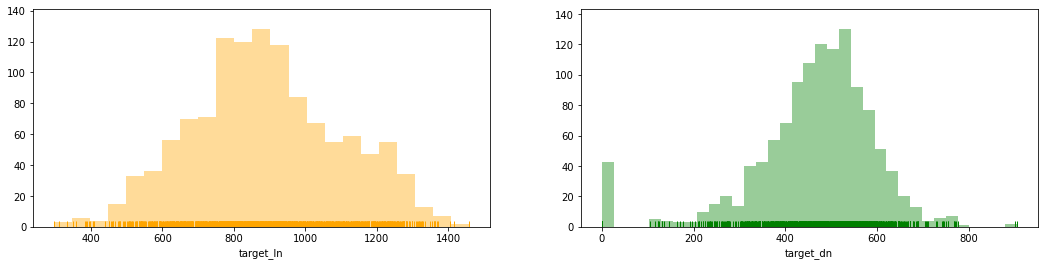

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
sns.distplot(train["target_ln"], ax = ax[0], color = 'orange', kde = False, rug = True)
sns.distplot(train["target_dn"], ax = ax[1], color = 'green', kde = False, rug = True)
plt.show()

정규 분포에 가까운 히스토그램 보임

=> 저녁 target에 0명인 날이 존재. 이상치인지 확인

### 타깃 (시계열 시각화)

코로나 전후 간의 차이 확인

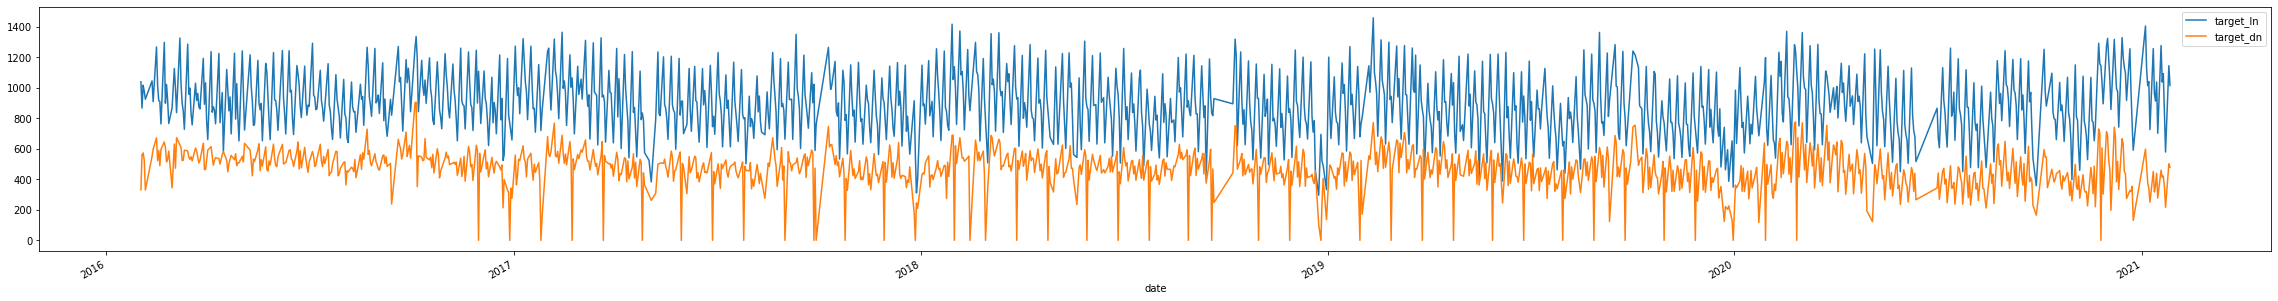

In [ ]:
train.plot(x = 'date', y = ['target_ln', 'target_dn'], figsize = (40, 5))
plt.show()

=> 코로나 전후간의 차이는 크게 드러나지 않음

(~2020) 까지 0명인 날이 존재

(2021~) 부터는 0명인 날이 존재하지 않음

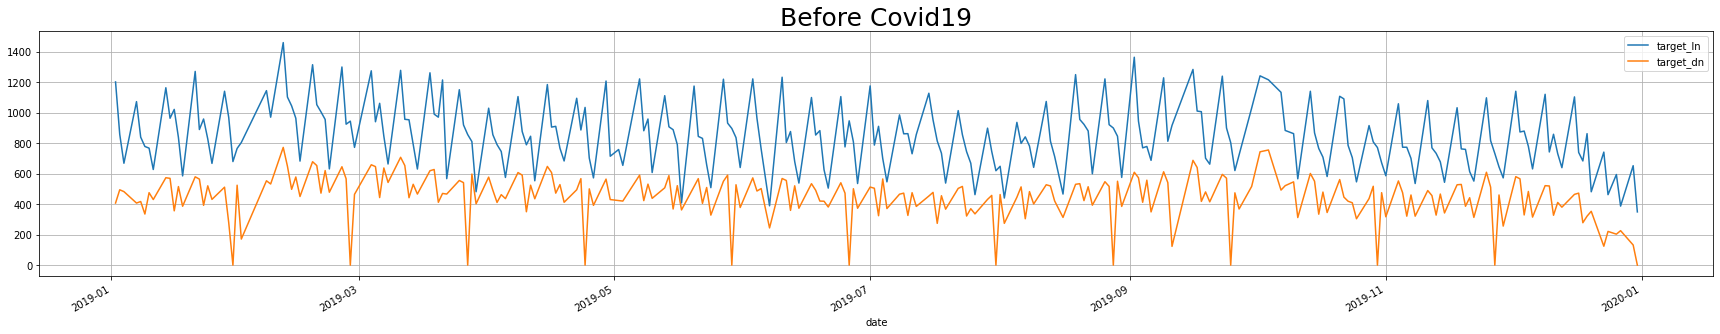

In [ ]:
before_covid = train[train['date'].dt.year == 2019][['date', 'target_ln', 'target_dn']]
before_covid.plot(x = 'date', y = ['target_ln', 'target_dn'], figsize = (30, 5), grid = True)
plt.title('Before Covid19', fontsize = 25)
plt.show()

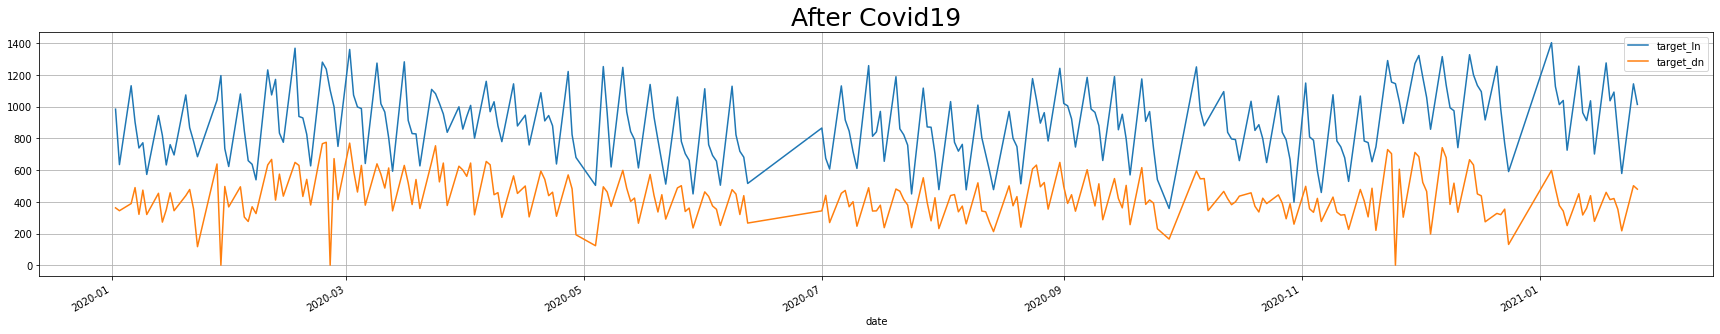

In [ ]:
after_covid = train[train['date'].dt.year >= 2020][['date', 'target_ln', 'target_dn']]
after_covid.plot(x = 'date', y = ['target_ln', 'target_dn'], figsize = (30, 5), grid = True)
plt.title('After Covid19', fontsize = 25)
plt.show()

In [ ]:
print('점심:', '2019 - ', round(before_covid.target_ln.mean(), 2), ', 2020 - ', round(after_covid.target_ln.mean(), 2))
print('저녁:', '2019 - ', round(before_covid.target_dn.mean(), 2), ', 2020 - ', round(after_covid.target_dn.mean(), 2))

점심: 2019 -  850.51 , 2020 -  890.97
저녁: 2019 -  445.39 , 2020 -  428.34


코로나로 인한 이용자 수 차이는 딱히 보이지 않았음.

중식 인원은 오히려 증가함


### 사원 수 (시계열 시각화)

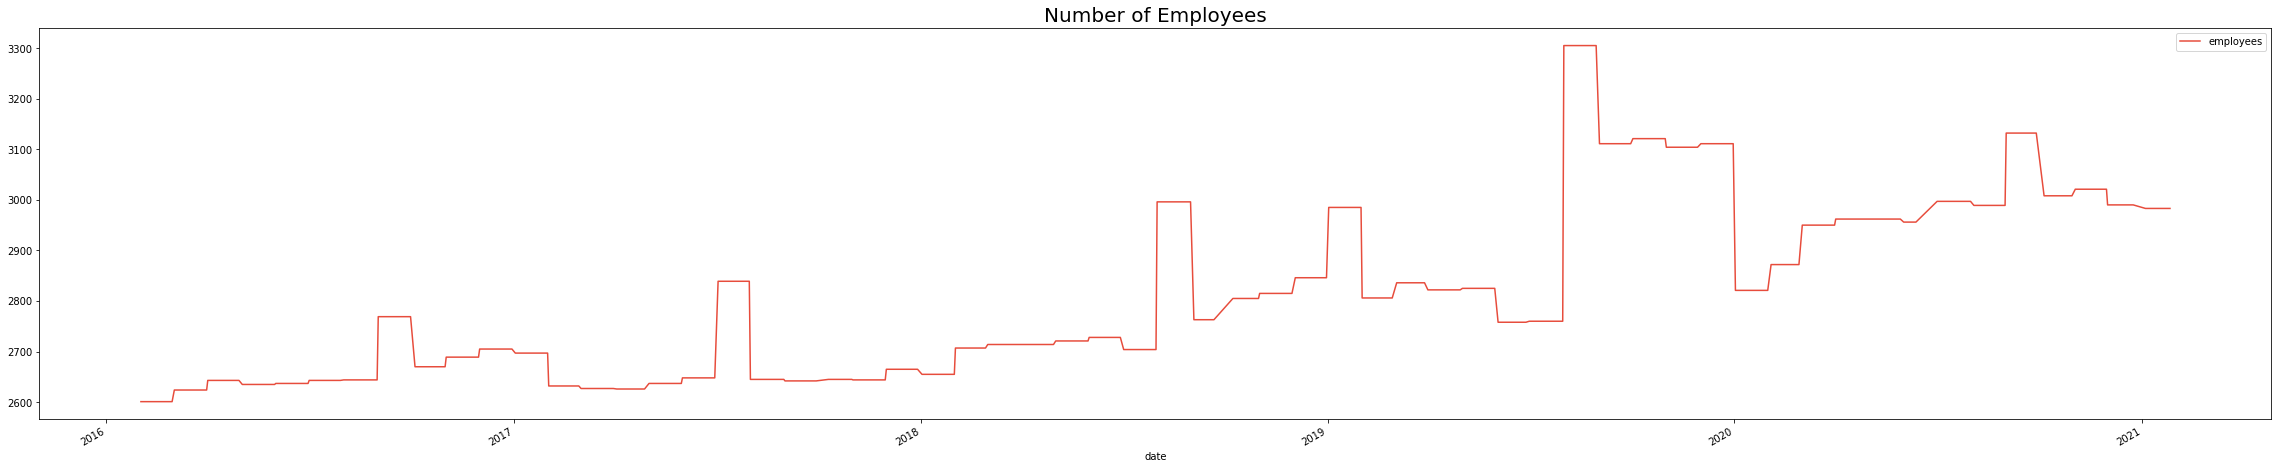

In [ ]:
train.plot(x = 'date', y = 'employees', figsize = (40, 8), c = "#e74c3c")
plt.title("Number of Employees", fontsize = 20)
plt.show()

정원수가 조금씩 증가하는 양상을 보이지만, 2019년과 비교했을때 2020년의 정원수가 더 많다고 볼 수는 없음

### 석식 0명인 데이터 확인

In [ ]:
train[train.target_dn == 0][['date',  'dayoff', 'bustrip', 'ovtime', 'remote', 'dow', 'dn', 'target_dn']]

,date,dayoff,bustrip,ovtime,remote,dow,dn,target_dn
204,2016-11-30,68,207,0,0.0,3,*,0.0
224,2016-12-28,166,225,0,0.0,3,*,0.0
244,2017-01-25,79,203,0,0.0,3,*,0.0
262,2017-02-22,75,252,0,0.0,3,*,0.0
281,2017-03-22,53,235,0,0.0,3,*,0.0
306,2017-04-26,45,304,0,0.0,3,*,0.0
327,2017-05-31,43,265,0,0.0,3,자기계발의날,0.0
346,2017-06-28,58,259,0,0.0,3,*자기계발의날*,0.0
366,2017-07-26,254,246,0,0.0,3,가정의날,0.0
392,2017-09-01,177,303,45,0.0,5,*,0.0


월별 마지막 (또는 그 전 주) 수요일(dow가 3인 날)은 '자기개발의 날' - 저녁메뉴가 완전히 빈칸

저녁 메뉴 제공되는데도 0명인 날

=> 2017-09-27 : 황금연휴, 2018-02-14 설날 연휴 전날

## 변수별 상관관계 시각화

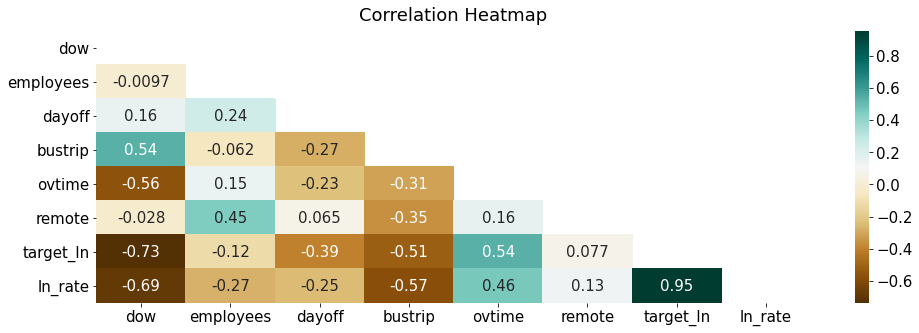

In [ ]:
mask = np.triu(np.ones_like(train_ln.corr(), dtype=np.bool))
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(train_ln.corr(), 
            annot=True, 
            cmap="BrBG", 
            mask = mask)
ax.set_title('Correlation Heatmap', pad = 10)
plt.show()

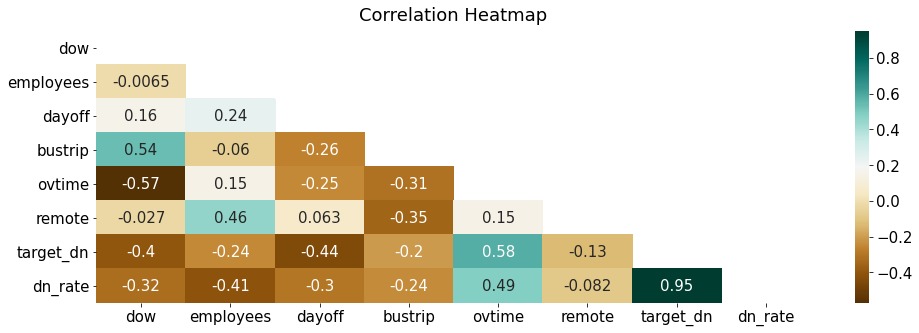

In [ ]:
mask = np.triu(np.ones_like(train_dn.corr(), dtype=np.bool))
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(train_dn.corr(), 
            annot=True, 
            cmap="BrBG", 
            mask = mask)
ax.set_title('Correlation Heatmap', pad = 10)
plt.show()

\<lunch\>

ovtime(시간외 근무자수) => 특이하게 석식이 아닌 중식에도 강한 상관관계 보임

bustrip(출장자수), dayoff(휴가자수) => 회사 내에 직원이 없음 (음의 상관관계 보임)

\<dinner\>

ovtime(시간외 근무자수) => 야근하는 사람이므로 양의 상관관계

dayoff(휴가자수) => 회사 내에 직원이 없음

lunch와 dinner는 인원수에 영향을 미치는 요인(ovtime, dayoff 등)을 공유하므로 target끼리의 상관관계가 높다고 생각됨!

### 산점도

heatmap과 동일! 직선으로 경향성 쉽게 표현

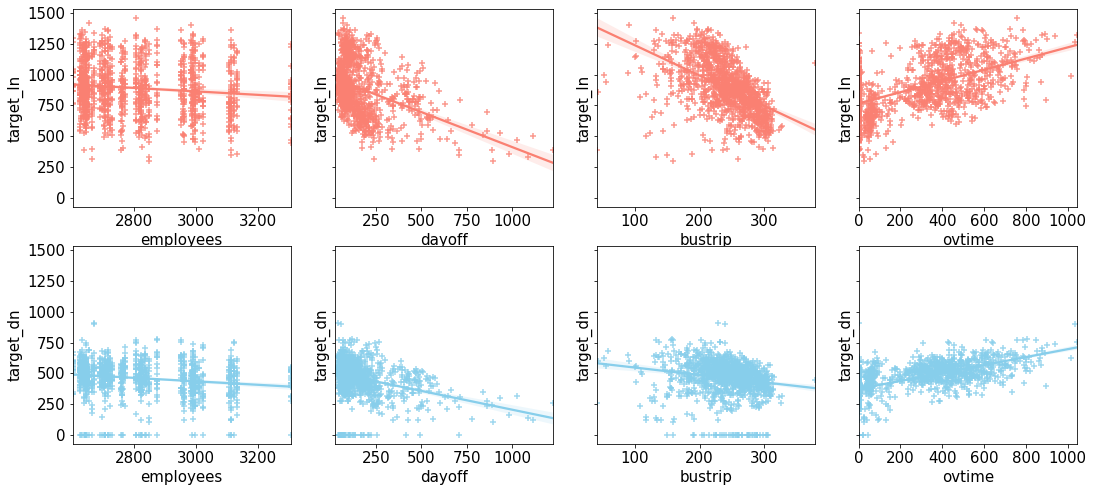

In [ ]:
fig, ax = plt.subplots(figsize = (18, 8), ncols = 4, nrows = 2, sharey=True)
plt.rcParams['font.size'] = 12
sns.color_palette("Paired")
train_features = ['employees', 'dayoff', 'bustrip', 'ovtime', 'employees', 'dayoff', 'bustrip', 'ovtime']
for i, feature in enumerate(train_features):
    row = int(i/4)
    col = i%4 
    if i < 4:
        sns.regplot(x=feature, y = 'target_ln', data = train, ax = ax[row][col], color = 'salmon', marker = '+')
    else: 
        sns.regplot(x=feature, y = 'target_dn', data = train, ax = ax[row][col], color = 'skyblue', marker = '+')

## 월별 & 요일별 패턴

### 요일별 식수량 평균 비교 (유의미한 차이 없음 -> 변수 추가 x)

In [ ]:
jan_ln, feb_ln, mar_ln, apr_ln, may_ln, jun_ln, jul_ln, aug_ln, sep_ln, oct_ln, nov_ln, dec_ln = [] ,[], [], [], [], [], [], [], [], [], [], []
jan_dn, feb_dn, mar_dn, apr_dn, may_dn, jun_dn, jul_dn, aug_dn, sep_dn, oct_dn, nov_dn, dec_dn = [] ,[], [], [], [], [], [], [], [], [], [], []


for i in range(train.shape[0]):
    if train['date'][i].month == 1:
        jan_ln.append(train['target_ln'])
        jan_dn.append(train['target_dn'])
    elif train['date'][i].month == 2:
        feb_ln.append(train['target_ln'])
        feb_dn.append(train['target_dn'])
    elif train['date'][i].month ==3:
        mar_ln.append(train['target_ln'])
        mar_dn.append(train['target_dn'])
    elif train['date'][i].month ==4:
        apr_ln.append(train['target_ln'])
        apr_dn.append(train['target_dn'])
    elif train['date'][i].month == 5:
        may_ln.append(train['target_ln'])
        may_dn.append(train['target_dn'])
    elif train['date'][i].month == 6:
        jun_ln.append(train['target_ln'])
        jun_dn.append(train['target_dn'])
    elif train['date'][i].month == 7:
        jul_ln.append(train['target_ln'])
        jul_dn.append(train['target_dn'])
    elif train['date'][i].month == 8:
        aug_ln.append(train['target_ln'])
        aug_dn.append(train['target_dn'])
    elif train['date'][i].month == 9:
        sep_ln.append(train['target_ln'])
        sep_dn.append(train['target_dn'])
    elif train['date'][i].month == 10:
        oct_ln.append(train['target_ln'])
        oct_dn.append(train['target_dn'])
    elif train['date'][i].month == 11:
        nov_ln.append(train['target_ln'])
        nov_dn.append(train['target_dn'])
    elif train['date'][i].month == 12:
        dec_ln.append(train['target_ln'])
        dec_dn.append(train['target_dn'])

month_ln = {'jan': np.mean(jan_ln), 'feb': np.mean(feb_ln), 'mar' : np.mean(mar_ln), 'apr': np.mean(apr_ln), 'may': np.mean(may_ln), 
            'jun': np.mean(jun_ln), 'jul': np.mean(jul_ln), 'aug': np.mean(aug_ln), 'sep': np.mean(sep_ln), 'oct':np.mean(oct_ln), 
            'nov': np.mean(nov_ln), 'dec': np.mean(dec_ln)}

month_dn = {'jan': np.mean(jan_dn), 'feb': np.mean(feb_dn), 'mar' : np.mean(mar_dn), 'apr': np.mean(apr_dn), 'may': np.mean(may_dn), 
            'jun': np.mean(jun_dn), 'jul': np.mean(jul_dn), 'aug': np.mean(aug_dn), 'sep': np.mean(sep_dn), 'oct':np.mean(oct_dn), 
            'nov': np.mean(nov_dn), 'dec': np.mean(dec_dn)}


plt.plot(list(month_ln.keys()), list(month_ln.values()))
plt.title('lunch')
plt.xlabel('month')
plt.ylabel('avg')
plt.show()

In [ ]:
plt.plot(list(month_dn.keys()), list(month_dn.values()))
plt.title('dinner')
plt.xlabel('month')
plt.ylabel('avg')
plt.show()

### 요일별 식수량 평균 비교(유의미한 차이 x)

In [ ]:
mon_ln, tue_ln, wed_ln, thr_ln, fri_ln, mon_dn, tue_dn, wed_dn, thr_dn, fri_dn = [],[],[],[],[],[],[],[],[],[]

for i in range(train.shape[0]):
    if train['dow'][i] == 1:
        mon_ln.append(train['target_ln'])
        mon_dn.append(train['target_dn'])
    elif train['dow'][i] == 2:
        tue_ln.append(train['target_ln'])
        tue_dn.append(train['target_dn'])
    elif train['dow'][i] ==3:
        wed_ln.append(train['target_ln'])
        wed_dn.append(train['target_dn'])
    elif train['dow'][i] ==4:
        thr_ln.append(train['target_ln'])
        thr_dn.append(train['target_dn'])
    elif train['dow'][i] == 5:
        fri_ln.append(train['target_ln'])
        fri_dn.append(train['target_dn'])


        
week_ln = {'mon' : np.mean(mon_ln), 'tue':np.mean(tue_ln), 'wed':np.mean(wed_ln), 'thr' : np.mean(thr_ln), 'fri':np.mean(fri_ln)}
week_dn = {'mon' : np.mean(mon_dn), 'tue':np.mean(tue_dn), 'wed':np.mean(wed_dn), 'thr' : np.mean(thr_dn), 'fri':np.mean(fri_dn)}
plt.plot(list(week_ln.keys()), list(week_ln.values()))
plt.title('lunch')
plt.xlabel('week')
plt.ylabel('avg')
plt.show()

In [ ]:
plt.plot(list(week_dn.keys()), list(week_dn.values()))
plt.title('dinner')
plt.xlabel('week')
plt.ylabel('avg')
plt.show()

In [ ]:
tmp = train[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'target_ln', 'target_dn']]
tmp['month'] = tmp['date'].dt.strftime("%m")

idx = train[train.target_dn == 0].index
tmp = train.drop(idx)
tmp['month'] = tmp['date'].dt.strftime("%m")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tmp_ln_16 = tmp[tmp['date'].apply(lambda x : x.year) == 2016].groupby(['dow', 'month'])['target_ln'].mean().reset_index().pivot('dow', 'month', 'target_ln')
tmp_ln_17 = tmp[tmp['date'].apply(lambda x : x.year) == 2017].groupby(['dow', 'month'])['target_ln'].mean().reset_index().pivot('dow', 'month', 'target_ln')
tmp_ln_18 = tmp[tmp['date'].apply(lambda x : x.year) == 2018].groupby(['dow', 'month'])['target_ln'].mean().reset_index().pivot('dow', 'month', 'target_ln')
tmp_ln_19 = tmp[tmp['date'].apply(lambda x : x.year) == 2019].groupby(['dow', 'month'])['target_ln'].mean().reset_index().pivot('dow', 'month', 'target_ln')
tmp_ln_20 = tmp[tmp['date'].apply(lambda x : x.year) == 2020].groupby(['dow', 'month'])['target_ln'].mean().reset_index().pivot('dow', 'month', 'target_ln')
tmp_ln_21 = tmp[tmp['date'].apply(lambda x : x.year) == 2021].groupby(['dow', 'month'])['target_ln'].mean().reset_index().pivot('dow', 'month', 'target_ln')

In [ ]:
tmp_dn_16 = tmp[tmp['date'].apply(lambda x : x.year) == 2016].groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')
tmp_dn_17 = tmp[tmp['date'].apply(lambda x : x.year) == 2017].groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')
tmp_dn_18 = tmp[tmp['date'].apply(lambda x : x.year) == 2018].groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')
tmp_dn_19 = tmp[tmp['date'].apply(lambda x : x.year) == 2019].groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')
tmp_dn_20 = tmp[tmp['date'].apply(lambda x : x.year) == 2020].groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')
tmp_dn_21 = tmp[tmp['date'].apply(lambda x : x.year) == 2021].groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')

### 통합 월별 & 요일별 히트맵

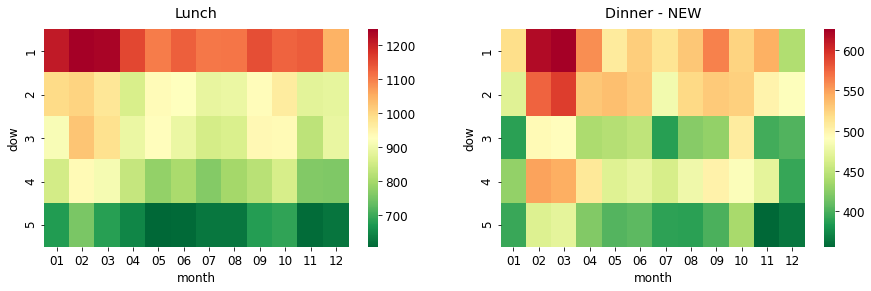

In [ ]:
# 자기개발의 날 (수요일) 삭제
idx = train[train.target_dn == 0].index
tmp = train.drop(idx)
tmp['month'] = tmp['date'].dt.strftime("%m")
tmp_ln = tmp.groupby(['dow', 'month'])['target_ln'].mean().reset_index().pivot('dow', 'month', 'target_ln')
tmp_dn2 = tmp.groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

sns.heatmap(tmp_ln, cmap='RdYlGn_r', ax=ax[0])
ax[0].set_title('Lunch', pad = 12)
sns.heatmap(tmp_dn2, cmap='RdYlGn_r', ax=ax[1])
ax[1].set_title('Dinner - NEW', pad = 12)

plt.show()

### 연도별 월별&요일별 히트맵

Text(0.5, 1.0, '2021')

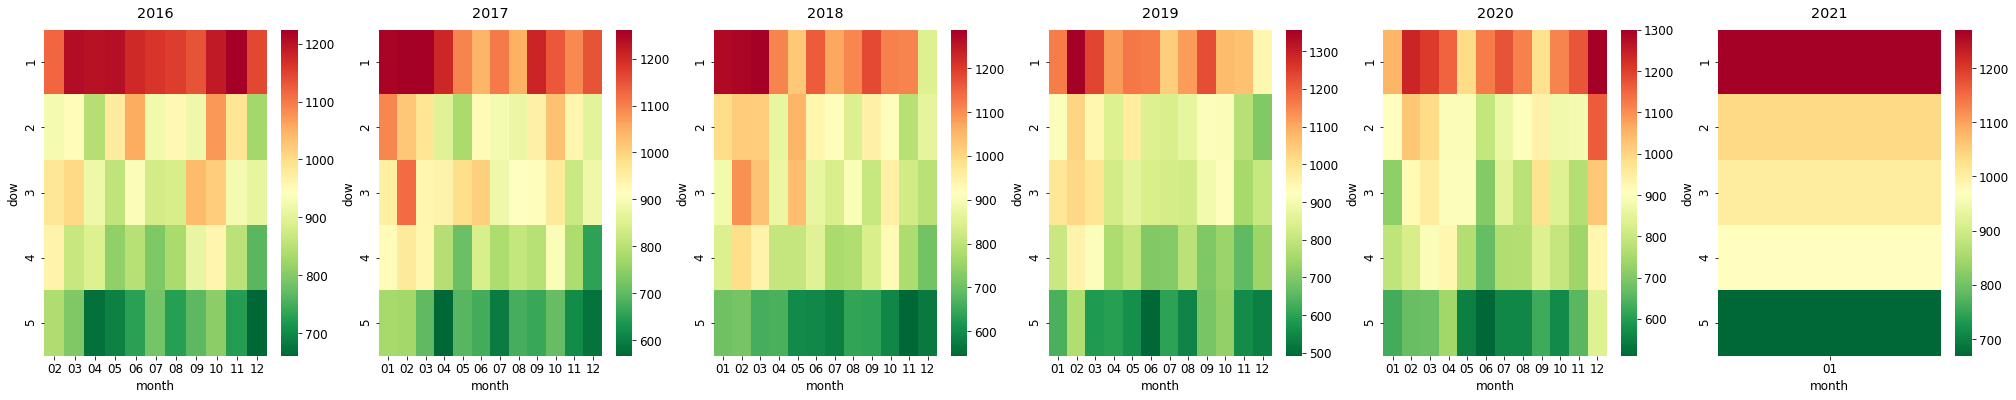

In [ ]:
# 연도별
fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (35, 6))

sns.heatmap(tmp_ln_16, cmap='RdYlGn_r', ax=ax[0])
ax[0].set_title('2016', pad = 12)

sns.heatmap(tmp_ln_17, cmap='RdYlGn_r', ax=ax[1])
ax[1].set_title('2017', pad = 12)

sns.heatmap(tmp_ln_18, cmap='RdYlGn_r', ax=ax[2])
ax[2].set_title('2018', pad = 12)

sns.heatmap(tmp_ln_19, cmap='RdYlGn_r', ax=ax[3])
ax[3].set_title('2019', pad = 12)

sns.heatmap(tmp_ln_20, cmap='RdYlGn_r', ax=ax[4])
ax[4].set_title('2020', pad = 12)

sns.heatmap(tmp_ln_21, cmap='RdYlGn_r', ax=ax[5])
ax[5].set_title('2021', pad = 12)

Text(0.5, 1.0, '2021')

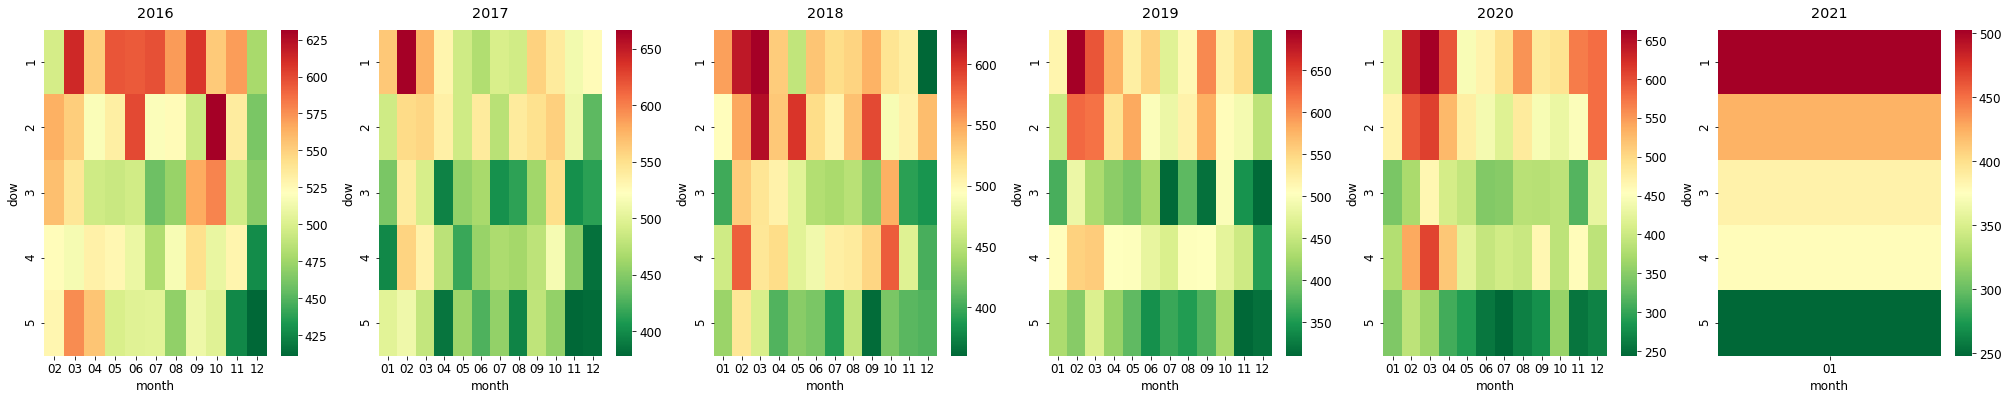

In [ ]:
# 연도별
fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (35, 6))

sns.heatmap(tmp_dn_16, cmap='RdYlGn_r', ax=ax[0])
ax[0].set_title('2016', pad = 12)

sns.heatmap(tmp_dn_17, cmap='RdYlGn_r', ax=ax[1])
ax[1].set_title('2017', pad = 12)

sns.heatmap(tmp_dn_18, cmap='RdYlGn_r', ax=ax[2])
ax[2].set_title('2018', pad = 12)

sns.heatmap(tmp_dn_19, cmap='RdYlGn_r', ax=ax[3])
ax[3].set_title('2019', pad = 12)

sns.heatmap(tmp_dn_20, cmap='RdYlGn_r', ax=ax[4])
ax[4].set_title('2020', pad = 12)

sns.heatmap(tmp_dn_21, cmap='RdYlGn_r', ax=ax[5])
ax[5].set_title('2021', pad = 12)

\<lunch\>

월요일에 압도적으로 이용자가 많음

> 특히 1-3월 이용자 수가 많음

금요일에 이용자 수가 매우 적음

> 특히 05-06, 11-12월 이용자 수가 적음

\<dinner\>

월, 화에 이용자 수가 많은 편
> 특히 2-3월 이용자 수가 많음

수, 금에 이용자 수가 적은 편
> 특히 1, 7, 11-12월

=> 요일에 따른 인원수 차이 극명

## 회사 직원 수

잠재적으로 점심, 저녁을 먹을 사람들

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


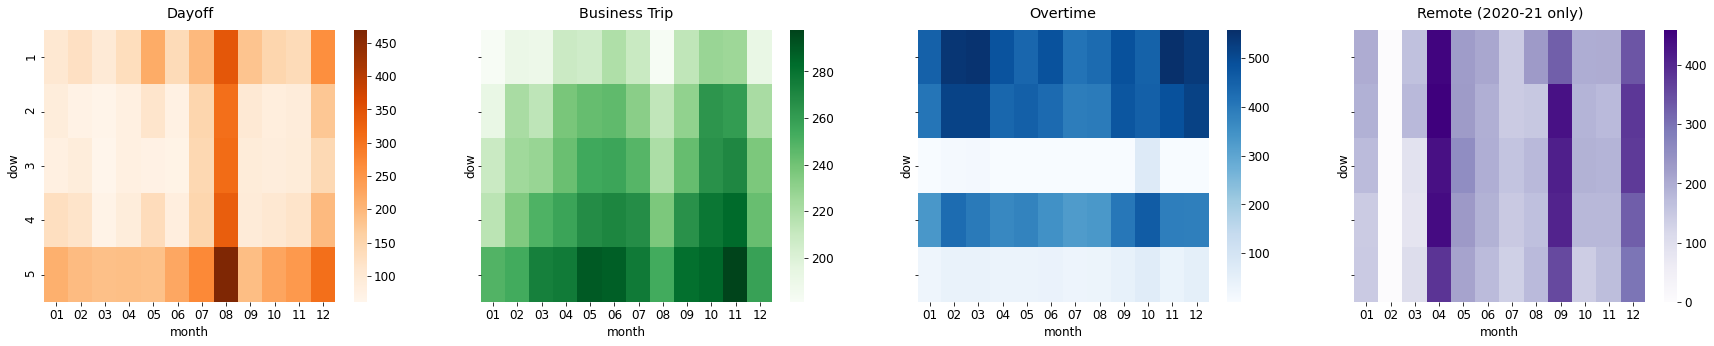

In [ ]:
before = train['date'].dt.year < 2020
after = train['date'].dt.year >= 2020

def heatmap_viz(df): 
    df['month'] = df['date'].dt.strftime("%m")
    before = df['date'].dt.year < 2020
    after = df['date'].dt.year >= 2020

    tmp_dayoff = df.groupby(['dow', 'month'])['dayoff'].mean().reset_index().pivot('dow', 'month', 'dayoff')
    tmp_bustrip = df.groupby(['dow', 'month'])['bustrip'].mean().reset_index().pivot('dow', 'month', 'bustrip')
    tmp_ovtime = df.groupby(['dow', 'month'])['ovtime'].mean().reset_index().pivot('dow', 'month', 'ovtime')
    tmp_remote_after = df[after].groupby(['dow', 'month'])['remote'].mean().reset_index().pivot('dow', 'month', 'remote')

    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (30, 5), sharey = True)

    sns.heatmap(tmp_dayoff, cmap='Oranges', ax=ax[0])   #1 
    ax[0].set_title('Dayoff', pad = 12)
    sns.heatmap(tmp_bustrip, cmap='Greens', ax=ax[1])   #2 
    ax[1].set_title('Business Trip', pad = 12)
    sns.heatmap(tmp_ovtime, cmap='Blues', ax=ax[2])   #3
    ax[2].set_title('Overtime', pad = 12)
    sns.heatmap(tmp_remote_after, cmap='Purples', ax=ax[3])   # 4
    ax[3].set_title('Remote (2020-21 only)', pad = 12)
   
    plt.show()

df = train[['date', 'dow', 'dayoff', 'bustrip', 'ovtime', 'remote']]
heatmap_viz(df)

\<상대적으로 인원수가 많은 월, 요일\>

* 휴가자수 (Dayoff): 월/금, 7/8/12월
* 출장자수 (Business Trip) : 금, 5/6/9/10/11월

  점심 이용자수가 금요일에 매우 적었던 것을 보면, 당연한 결과입니다. 출장을 한다는 것은 하루종일 회사 내에 없는 것이니까요.
* 시간외근무자수 (Overtime) : 월/화/목, 2/3월

  저녁 이용자수가 수, 금요일에 적은 편인 것을 생각해보면, 자연스러운 결과입니다.
* 재택근무자수 (Remote) : 4/9/12월

### 회사 내의 직원수

In [ ]:
test = test.copy()
test['in_office'] = test['employees'] - (test['dayoff'] + test['bustrip'] + test['remote'])
test['month'] = pd.to_numeric(test['date'].dt.strftime("%m"))
test.drop(['date', 'brk', 'ln', 'dn'], axis=1, inplace=True)

In [ ]:
df = train[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'target_ln', 'target_dn']]
df['in_office'] = df['employees'] - (df['dayoff'] + df['bustrip'] + df['remote'])
df['month'] = df['date'].dt.strftime("%m")
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,dow,employees,dayoff,bustrip,ovtime,remote,target_ln,target_dn,in_office,month
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2401.0,02
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2378.0,02
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2365.0,02
3,2016-02-04,4,2601,104,220,355,0.0,978.0,525.0,2277.0,02
4,2016-02-05,5,2601,278,181,34,0.0,925.0,330.0,2142.0,02


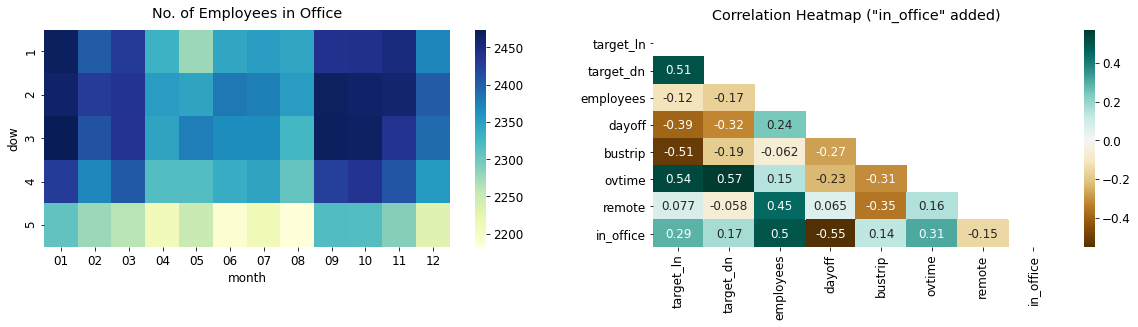

In [ ]:
tmp = df.groupby(['dow', 'month'])['in_office'].mean().reset_index().pivot('dow', 'month', 'in_office')

# Heatmap
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))

sns.heatmap(tmp, cmap='YlGnBu', ax = ax[0])    # 1 
ax[0].set_title('No. of Employees in Office', pad = 12)

df_corr = df[['target_ln', 'target_dn', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'in_office']]   # 2
mask = np.triu(np.ones_like(df_corr.corr(), dtype=np.bool))
sns.heatmap(df_corr.corr(), 
            annot=True, 
            cmap="BrBG", 
            mask = mask, 
            ax =ax[1])
ax[1].set_title('Correlation Heatmap ("in_office" added)', pad = 10)
plt.show()

금요일에는 회사 내에 있는 인원 자체가 적음

1-3월, 9-11월에 가장 많음

회사에 있는 인원수 (in_office)에 따른 상관관계

0.29, 0.17로 약한 양의 상관관계 보임

## 날짜변수 상관관계

### dow 원시 변수 추가

In [ ]:
train_ln['month'] = pd.to_numeric(train_ln['date'].dt.month)
train_dn['month'] = pd.to_numeric(train_dn['date'].dt.month)

test_ln['month'] = pd.to_numeric(test_ln['date'].dt.month)
test_dn['month'] = pd.to_numeric(test_dn['date'].dt.month)

In [ ]:
train_ln['year'] = pd.to_numeric(train_ln['date'].dt.year)
train_dn['year'] = pd.to_numeric(train_dn['date'].dt.year)

test_ln['year'] = pd.to_numeric(test_ln['date'].dt.year)
test_dn['year'] = pd.to_numeric(test_dn['date'].dt.year)

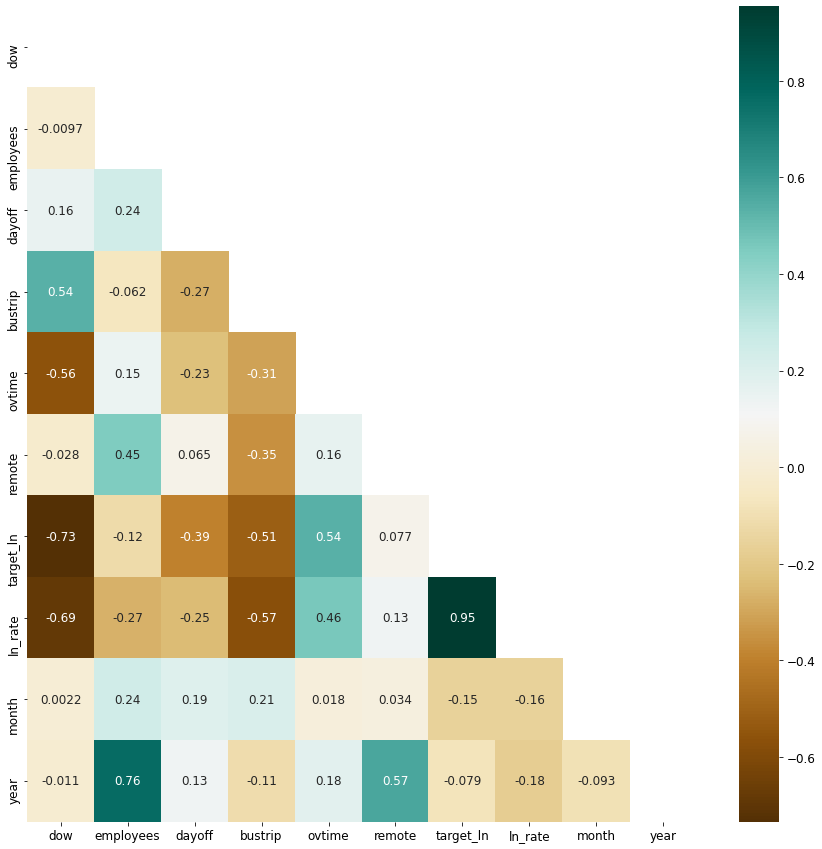

In [ ]:
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(train_ln.corr(), dtype=np.bool))
sns.heatmap(train_ln.corr(), 
            annot=True, 
            cmap="BrBG", 
            mask = mask)

plt.show()

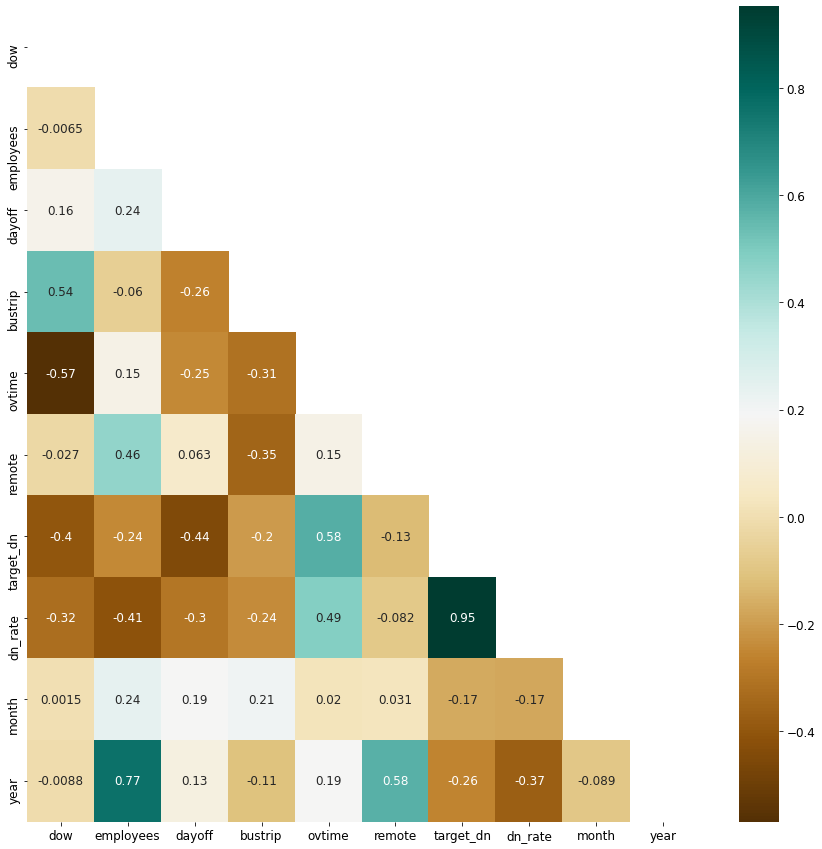

In [ ]:
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(train_dn.corr(), dtype=np.bool))
sns.heatmap(train_dn.corr(), 
            annot=True, 
            cmap="BrBG", 
            mask = mask)
plt.show()

dow는 target_ln과 -0.73으로 강한 음의 상관관계를, target_dn과는 -0.31로 음의 상관관계를 보였다.

month는 target_ln과 -0.15, target_dn과 -0.13으로 약한 음의 상관관계를 보였으며,

in_office는 각 0.29, 0.17로 양의 상관관계를 보였다.

=> 세 가지 변수 모두 유의한 수준의 상관관계를 지니고 있다 판단하여, 모델 학습에 포함시킨다.

In [ ]:
train_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,ln_rate,kimchi,side,month,year
0,2016-02-01,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...",1039.0,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,0.432736,[포기김치],[요구르트],2,2016
1,2016-02-02,2,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...",867.0,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,0.364592,[배추겉절이],[요구르트],2,2016
2,2016-02-03,3,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...",1017.0,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,0.430021,[포기김치],[요구르트],2,2016
3,2016-02-04,4,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...",978.0,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,0.429513,[포기김치],[요구르트],2,2016
4,2016-02-05,5,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...",925.0,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,0.431839,[포기김치],[요구르트],2,2016


In [ ]:
test_ln.head()

,date,dow,employees,dayoff,bustrip,ovtime,remote,ln,bob,gook,banchan1,banchan2,banchan3,else,month,year
0,2021-01-27,3,2983,88,182,5,358.0,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,"[포기김치, 양상추샐러드*딸기D]",1,2021
1,2021-01-28,4,2983,104,212,409,348.0,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,"[겉절이김치, 양상추샐러드*오미자D]",1,2021
2,2021-01-29,5,2983,270,249,0,294.0,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,"[포기김치, 양상추샐러드*파인요거트D]",1,2021
3,2021-02-01,1,2924,108,154,538,322.0,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,"[포기김치, 양상추샐러드*망고D]",2,2021
4,2021-02-02,2,2924,62,186,455,314.0,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,"[알타리김치/사과푸딩, 양상추샐러드*오리엔탈D]",2,2021


## 기본 모델 성능 평가

현재 xgboost, lgbm으로 엔지니어링 성능 평가 // 요인 중요도 시각화 위해서

회귀 모델이나 다른 모델 추가할 수 있음

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### target 분리

80% (964 row)를 train, 20% (241 row)를 test data로 사용

In [ ]:
def split_ln(df, rate=0.25):
  X_train = df[0:int(len(df)*(1-rate))-1]
  X_test = df[int(len(df)*(1-rate)):].reset_index(drop=True)

  train_ln_y = X_train['target_ln'].values
  test_ln_y = X_test['target_ln'].values

  X_train.drop('target_ln',axis=1, inplace=True)
  X_test.drop('target_ln', axis=1, inplace=True)

  return X_train, X_test, train_ln_y, test_ln_y

def split_dn(df, rate=0.25):
  X_train = df[0:int(len(df)*(1-rate))-1]
  X_test = df[int(len(df)*(1-rate)):].reset_index(drop=True)

  train_dn_y = X_train['target_dn'].values
  test_dn_y = X_test['target_dn'].values

  X_train.drop('target_dn',axis=1, inplace=True)
  X_test.drop('target_dn', axis=1, inplace=True)

  return X_train, X_test, train_dn_y, test_dn_y

In [ ]:
train_ln_df = train_ln[['dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'target_ln', 'month', 'year']]
#train_dn_df = train_dn[['dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'target_dn', 'gook_rate', 'banchan1_rate', 'banchan2_rate', 'banchan3_rate', 'rate', 'month']]

test_ln_df = test_ln[['dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'month', 'year']]
#test_dn_df = test_dn[['dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'gook_rate', 'banchan1_rate', 'banchan2_rate', 'banchan3_rate', 'rate', 'month']]

train_dn_df = train_dn[['dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'target_dn', 'month', 'year']]
test_dn_df = test_dn[['dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'month', 'year']]

In [ ]:
# train - test split
X_train_ln, X_test_ln, train_ln_y, test_ln_y = train_test_split(train_ln_df.drop('target_ln', axis=1), train_ln_df['target_ln'], test_size=0.2)
X_train_dn, X_test_dn, train_dn_y, test_dn_y = train_test_split(train_dn_df.drop('target_dn', axis=1), train_dn_df['target_dn'], test_size=0.2)

In [ ]:
# X_train_ln, X_test_ln, train_ln_y, test_ln_y = split_ln(train_ln_df, 0.25)
# X_train_dn, X_test_dn, train_dn_y, test_dn_y = split_dn(train_dn_df, 0.25)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

scaler = RobustScaler()
X_train_rb_ln = scaler.fit_transform(X_train_ln)
X_test_rb_ln = scaler.transform(X_test_ln)
X_train_rb_dn = scaler.fit_transform(X_train_dn)
X_test_rb_dn = scaler.transform(X_test_dn)

scaler = Normalizer()
X_train_nm_ln = scaler.fit_transform(X_train_ln)
X_test_nm_ln = scaler.transform(X_test_ln)
X_train_nm_dn = scaler.fit_transform(X_train_dn)
X_test_nm_dn = scaler.transform(X_test_dn)

### 모델 생성 및 학습

In [ ]:
def model_fit(model_list, train_X, train_y, test_X, test_y):
  for model in model_list:
    model.fit(train_X, train_y)
    mae = MAE(test_y, model.predict(test_X))
    print(model.__class__.__name__, ":", mae)

#### 회귀모델

In [ ]:
# 알고리즘
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import ARDRegression, BayesianRidge

In [ ]:
knn_ln = KNeighborsRegressor()
knn_dn = KNeighborsRegressor()

dt_ln = DecisionTreeRegressor()
dt_dn = DecisionTreeRegressor()

rf_ln = RandomForestRegressor()
rf_dn = RandomForestRegressor()

svr_ln = SVR()
svr_dn = SVR()

linear_ln = LinearRegression()
linear_dn = LinearRegression()

ridge_ln, lasso_ln, elasticnet_ln = Ridge(), Lasso(), ElasticNet()
ridge_dn, lasso_dn, elasticnet_dn = Ridge(), Lasso(), ElasticNet()

ardr_ln, baysian_ln = ARDRegression(), BayesianRidge()
ardr_dn, baysian_dn = ARDRegression(), BayesianRidge()

ln_regression = [knn_ln, dt_ln, rf_ln, svr_ln, linear_ln, ridge_ln, lasso_ln, elasticnet_ln, ardr_ln, baysian_ln]
dn_regression = [knn_dn, dt_dn, rf_dn, svr_dn, linear_dn, ridge_dn, lasso_dn, elasticnet_dn, ardr_dn, baysian_dn]

In [ ]:
# non-scaled
print('non-scaled ln')
model_fit(ln_regression, X_train_ln, train_ln_y, X_test_ln, test_ln_y)
print('non-scaled dn')
model_fit(dn_regression, X_train_dn, train_dn_y, X_test_dn, test_dn_y)

non-scaled ln
KNeighborsRegressor : 99.23070539419086
DecisionTreeRegressor : 103.02489626556017
RandomForestRegressor : 65.6068049792531
SVR : 156.41735803422947
LinearRegression : 76.67268939951745
Ridge : 76.67644589259959
Lasso : 76.84109742636376
ElasticNet : 79.47129913283086
ARDRegression : 77.13007886805823
BayesianRidge : 76.77304877135346
non-scaled dn
KNeighborsRegressor : 52.81373390557939
DecisionTreeRegressor : 65.64377682403433
RandomForestRegressor : 47.9872103004292
SVR : 80.44909239230746
LinearRegression : 53.621289621618224
Ridge : 53.61624033781202
Lasso : 53.51183200953622
ElasticNet : 53.733486474059674
ARDRegression : 53.71936125345024
BayesianRidge : 56.344525153583824


In [ ]:
# robustscaler
print('robust_scaled ln')
model_fit(ln_regression, X_train_rb_ln, train_ln_y, X_test_rb_ln, test_ln_y)
print('robust_scaled dn')
model_fit(dn_regression, X_train_rb_dn, train_dn_y, X_test_rb_dn, test_dn_y)

robust_scaled ln
KNeighborsRegressor : 93.80082987551867
DecisionTreeRegressor : 98.43153526970954
RandomForestRegressor : 65.1969294605809
SVR : 158.2448130072073
LinearRegression : 76.67268939951761
Ridge : 76.70387300476335
Lasso : 77.300930697394
ElasticNet : 95.42902392956837
ARDRegression : 77.13008778654829
BayesianRidge : 76.7712761232354
robust_scaled dn
KNeighborsRegressor : 62.5030042918455
DecisionTreeRegressor : 66.11587982832619
RandomForestRegressor : 48.258669527897
SVR : 80.85713074751848
LinearRegression : 53.62128962161845
Ridge : 53.5757569910148
Lasso : 53.60366326954602
ElasticNet : 61.989900020717656
ARDRegression : 53.71978499486699
BayesianRidge : 53.51811621976548


In [ ]:
# normalizer
print('normalized ln')
model_fit(ln_regression, X_train_nm_ln, train_ln_y, X_test_nm_ln, test_ln_y)
print('normalized dn')
model_fit(dn_regression, X_train_nm_dn, train_dn_y, X_test_nm_dn, test_dn_y)

normalized ln
KNeighborsRegressor : 96.37759336099585
DecisionTreeRegressor : 91.70954356846472
RandomForestRegressor : 66.72460580912863
SVR : 156.4854226881894
LinearRegression : 78.87924065859842
Ridge : 129.40799980074686
Lasso : 133.56566544420988
ElasticNet : 156.59199754887902
ARDRegression : 79.75247393827617
BayesianRidge : 78.97099895278814
normalized dn
KNeighborsRegressor : 53.90987124463519
DecisionTreeRegressor : 60.223175965665234
RandomForestRegressor : 45.241673819742495
SVR : 80.6549805102023
LinearRegression : 56.352342817414595
Ridge : 62.81834415094477
Lasso : 67.55691059389979
ElasticNet : 84.36218987347435
ARDRegression : 56.73868995012572
BayesianRidge : 56.78136096451834


#### 부스팅 (xgb, lgbm) 모델

In [ ]:
# 부스팅 관련
xgb_ln = XGBRegressor(n_jobs=-1)
xgb_dn = XGBRegressor(n_jobs=-1)
lgbm_ln = LGBMRegressor(n_jobs=-1)
lgbm_dn = LGBMRegressor(n_jobs=-1)

In [ ]:
xgb_ln.fit(X_train_ln, train_ln_y)
xgb_dn.fit(X_train_dn, train_dn_y)
lgbm_ln.fit(X_train_ln, train_ln_y)
lgbm_dn.fit(X_train_dn, train_dn_y)

[21:08:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
print('non-scaled')
print('xgb_ln', MAE(test_ln_y, xgb_ln.predict(X_test_ln)))
print('xgb_dn', MAE(test_dn_y, xgb_dn.predict(X_test_dn)))
print('lgbm_ln', MAE(test_ln_y, lgbm_ln.predict(X_test_ln)))
print('lgbm_dn', MAE(test_dn_y, lgbm_dn.predict(X_test_dn)))

non-scaled
xgb_ln 61.044992913843686
xgb_dn 46.22230497040974
lgbm_ln 65.93397721403731
lgbm_dn 47.29923877929817


In [ ]:
xgb_ln.fit(X_train_rb_ln, train_ln_y)
xgb_dn.fit(X_train_rb_dn, train_dn_y)
lgbm_ln.fit(X_train_rb_ln, train_ln_y)
lgbm_dn.fit(X_train_rb_dn, train_dn_y)

[21:08:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
print('robust-scaled')
print('xgb_ln', MAE(test_ln_y, xgb_ln.predict(X_test_rb_ln)))
print('xgb_dn', MAE(test_dn_y, xgb_dn.predict(X_test_rb_dn)))
print('lgbm_ln', MAE(test_ln_y, lgbm_ln.predict(X_test_rb_ln)))
print('lgbm_dn', MAE(test_dn_y, lgbm_dn.predict(X_test_rb_dn)))

robust-scaled
xgb_ln 61.044992913843686
xgb_dn 46.19980919309952
lgbm_ln 66.00027979984557
lgbm_dn 48.26622609533142


In [ ]:
xgb_ln.fit(X_train_nm_ln, train_ln_y)
xgb_dn.fit(X_train_nm_dn, train_dn_y)
lgbm_ln.fit(X_train_nm_ln, train_ln_y)
lgbm_dn.fit(X_train_nm_dn, train_dn_y)

[21:08:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
print('normalized')
print('xgb_ln', MAE(test_ln_y, xgb_ln.predict(X_test_nm_ln)))
print('xgb_dn', MAE(test_dn_y, xgb_dn.predict(X_test_nm_dn)))
print('lgbm_ln', MAE(test_ln_y, lgbm_ln.predict(X_test_nm_ln)))
print('lgbm_dn', MAE(test_dn_y, lgbm_dn.predict(X_test_nm_dn)))

normalized
xgb_ln 62.87329810684647
xgb_dn 46.355958144552204
lgbm_ln 68.79256016042797
lgbm_dn 46.50999253513682


## optuna

In [ ]:
# colab 새로 열때마다 실행해야함
!pip install optuna

     |████████████████████████████████| 301 kB 12.9 MB/s 
     |████████████████████████████████| 164 kB 21.4 MB/s 
     |████████████████████████████████| 80 kB 6.2 MB/s 
     |████████████████████████████████| 75 kB 3.0 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 141 kB 23.8 MB/s 
     |████████████████████████████████| 111 kB 21.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=bf81ae9c2fc80e1be19814c9c47d0740cc8f6830fe4c387ec8f1479758858061
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
train_ln_X = pd.get_dummies(X_train_ln)
test_ln_X = pd.get_dummies(X_test_ln)

train_dn_X = pd.get_dummies(X_train_dn)
test_dn_X = pd.get_dummies(X_test_dn)

In [ ]:
def lgbm_ln(trial: Trial) -> float:
    params_lgb = {
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": 10000,
        "objective": "regression",
        "metric": "mae",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    

    model = LGBMRegressor(**params_lgb)
    model.fit(
        train_ln_X, train_ln_y,
        eval_set=[(train_ln_X, train_ln_y), (test_ln_X, test_ln_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    mae = MAE(test_ln_y, model.predict(test_ln_X))
    
    return mae

In [ ]:
def xgb_ln(trial: Trial) -> float:
    params_xgb = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": 10000,
        "objective": "reg:linear",
        "metric": "mae",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }

    model = XGBRegressor(**params_xgb)
    model.fit(
        train_ln_X, train_ln_y,
        eval_set=[(train_ln_X, train_ln_y), (test_ln_X, test_ln_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    mae = MAE(test_ln_y, model.predict(test_ln_X))
    
    return mae

In [ ]:
def lgbm_dn(trial: Trial) -> float:
    params_lgb = {
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": 10000,
        "objective": "regression",
        "metric": "mae",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    

    model = LGBMRegressor(**params_lgb)
    model.fit(
        train_dn_X, train_dn_y,
        eval_set=[(train_dn_X, train_dn_y), (test_dn_X, test_dn_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    mae = MAE(test_dn_y, model.predict(test_dn_X))
    
    return mae

In [ ]:
def xgb_dn(trial: Trial) -> float:
    params_xgb = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": 10000,
        "objective": "reg:linear",
        "metric": "mae",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }

    model = XGBRegressor(**params_xgb)
    model.fit(
        train_dn_X, train_dn_y,
        eval_set=[(train_dn_X, train_dn_y), (test_dn_X, test_dn_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    mae = MAE(test_dn_y, model.predict(test_dn_X))
    
    return mae

In [ ]:
sampler = TPESampler()
study_lgbm_ln = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_lgbm_ln.optimize(lgbm_ln, n_trials=50)
print("Best Score:", study_lgbm_ln.best_value)
print("Best trial:", study_lgbm_ln.best_trial.params)

[I 2021-07-19 21:08:15,027] A new study created in memory with name: lgbm_parameter_opt
[I 2021-07-19 21:08:15,167] Trial 0 finished with value: 65.02051562092339 and parameters: {'learning_rate': 0.024893300096790975, 'reg_alpha': 1.3413964023030886e-05, 'reg_lambda': 0.05223569983059787, 'max_depth': 11, 'num_leaves': 239, 'colsample_bytree': 0.8445929813626736, 'subsample': 0.5411083673492825, 'subsample_freq': 6, 'min_child_samples': 55, 'max_bin': 446}. Best is trial 0 with value: 65.02051562092339.
[I 2021-07-19 21:08:15,268] Trial 1 finished with value: 61.360434994656416 and parameters: {'learning_rate': 0.04310685064040331, 'reg_alpha': 2.776377813644968e-05, 'reg_lambda': 0.055336784703407256, 'max_depth': 15, 'num_leaves': 117, 'colsample_bytree': 0.7832244202669199, 'subsample': 0.6407774884034899, 'subsample_freq': 2, 'min_child_samples': 44, 'max_bin': 440}. Best is trial 1 with value: 61.360434994656416.
[I 2021-07-19 21:08:15,349] Trial 2 finished with value: 85.9371360

Best Score: 58.86339216838287
Best trial: {'learning_rate': 0.0662785199043722, 'reg_alpha': 2.4025568215590165e-05, 'reg_lambda': 0.0006965626540208953, 'max_depth': 3, 'num_leaves': 89, 'colsample_bytree': 0.9957624229386236, 'subsample': 0.580641600219932, 'subsample_freq': 2, 'min_child_samples': 20, 'max_bin': 472}


In [ ]:
best_lgbm_ln = LGBMRegressor(**study_lgbm_ln.best_trial.params)

In [ ]:
best_lgbm_ln.fit(train_ln_X, train_ln_y, eval_set=[(train_ln_X, train_ln_y), (test_ln_X, test_ln_y)], early_stopping_rounds=100, verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.9957624229386236, importance_type='split',
              learning_rate=0.0662785199043722, max_bin=472, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=89, objective=None,
              random_state=None, reg_alpha=2.4025568215590165e-05,
              reg_lambda=0.0006965626540208953, silent=True,
              subsample=0.580641600219932, subsample_for_bin=200000,
              subsample_freq=2)

In [ ]:
# 추론
lgbm_pred_ln = best_lgbm_ln.predict(test_ln_X)
lgbm_pred_ln

array([1186.62008007,  705.02747024, 1102.74021204,  704.87031356,
        697.0942297 ,  976.57029693,  921.54933962,  841.47087123,
        718.07118337, 1071.29165334,  891.79224824, 1014.92644905,
       1272.68993606,  799.82308919,  907.93152511, 1023.12616198,
        671.77004639,  760.30255158, 1048.69738337, 1154.37491241,
        931.49820477, 1087.8210415 ,  893.16684949,  913.10357499,
        646.34211713,  909.56188425, 1167.97116726,  823.77788582,
        958.31739668,  887.70837917, 1149.54690835, 1254.099866  ,
        891.36481868, 1241.99267073,  910.95754884,  539.03310847,
       1161.2515179 ,  693.04937587,  763.75537132,  829.83869014,
        744.93111473,  879.42455304,  890.97006804,  634.26174096,
       1053.13835093,  684.82457447,  553.79444052,  902.8215817 ,
        839.52145359, 1173.25811022,  776.27567042,  767.17409625,
        856.62311066,  707.07137398, 1013.59567335,  619.99604373,
        838.6124669 ,  923.27625413,  924.86430338,  581.44882

In [ ]:
sampler = TPESampler()
study_xgb_ln = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_xgb_ln.optimize(xgb_ln, n_trials=50)
print("Best Score:", study_xgb_ln.best_value)
print("Best trial:", study_xgb_ln.best_trial.params)

[I 2021-07-19 21:08:20,305] A new study created in memory with name: xgb_parameter_opt


[21:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:20,998] Trial 0 finished with value: 69.50861342813958 and parameters: {'learning_rate': 0.06599913780901635, 'reg_alpha': 1.233492669080626e-05, 'reg_lambda': 0.050737108596640164, 'max_depth': 13, 'num_leaves': 231, 'colsample_bytree': 0.9446996506344296, 'subsample': 0.8658085505990267, 'subsample_freq': 7, 'min_child_samples': 66, 'max_bin': 438}. Best is trial 0 with value: 69.50861342813958.


[21:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:22,836] Trial 1 finished with value: 84.0540692974423 and parameters: {'learning_rate': 0.0167842154332851, 'reg_alpha': 2.831055044455677e-05, 'reg_lambda': 0.0009568959155863018, 'max_depth': 16, 'num_leaves': 242, 'colsample_bytree': 0.44909345510008597, 'subsample': 0.9490586532858223, 'subsample_freq': 5, 'min_child_samples': 6, 'max_bin': 402}. Best is trial 0 with value: 69.50861342813958.


[21:08:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:24,123] Trial 2 finished with value: 62.16238422314656 and parameters: {'learning_rate': 0.028234418901767644, 'reg_alpha': 1.8906865865084566e-05, 'reg_lambda': 0.010342625476080714, 'max_depth': 1, 'num_leaves': 128, 'colsample_bytree': 0.6761376229263891, 'subsample': 0.3967521883139256, 'subsample_freq': 10, 'min_child_samples': 90, 'max_bin': 367}. Best is trial 2 with value: 62.16238422314656.


[21:08:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:24,844] Trial 3 finished with value: 71.78351273279468 and parameters: {'learning_rate': 0.09279035669817431, 'reg_alpha': 1.4284222758249434e-05, 'reg_lambda': 0.06285275810545542, 'max_depth': 16, 'num_leaves': 13, 'colsample_bytree': 0.8153237549640653, 'subsample': 0.8871431312068871, 'subsample_freq': 1, 'min_child_samples': 56, 'max_bin': 282}. Best is trial 2 with value: 62.16238422314656.


[21:08:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:25,666] Trial 4 finished with value: 70.31499851590866 and parameters: {'learning_rate': 0.07226608352580736, 'reg_alpha': 1.553812666574675e-05, 'reg_lambda': 0.005492624545513531, 'max_depth': 20, 'num_leaves': 15, 'colsample_bytree': 0.8662021154831536, 'subsample': 0.4695520369059305, 'subsample_freq': 3, 'min_child_samples': 30, 'max_bin': 359}. Best is trial 2 with value: 62.16238422314656.


[21:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:26,316] Trial 5 finished with value: 81.77067432957566 and parameters: {'learning_rate': 0.07035836278985916, 'reg_alpha': 2.7217081483538125e-05, 'reg_lambda': 0.026043502426328264, 'max_depth': 17, 'num_leaves': 149, 'colsample_bytree': 0.40806751936888874, 'subsample': 0.7660922000335977, 'subsample_freq': 9, 'min_child_samples': 15, 'max_bin': 293}. Best is trial 2 with value: 62.16238422314656.


[21:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:27,479] Trial 6 finished with value: 68.0861569479788 and parameters: {'learning_rate': 0.05175543613903736, 'reg_alpha': 2.4648223011893774e-05, 'reg_lambda': 0.05346949949849004, 'max_depth': 17, 'num_leaves': 234, 'colsample_bytree': 0.909387369124566, 'subsample': 0.9006625392411078, 'subsample_freq': 1, 'min_child_samples': 87, 'max_bin': 306}. Best is trial 2 with value: 62.16238422314656.


[21:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:28,803] Trial 7 finished with value: 75.32628432151193 and parameters: {'learning_rate': 0.03059308325230449, 'reg_alpha': 8.922284359601807e-06, 'reg_lambda': 0.007651165579813071, 'max_depth': 16, 'num_leaves': 23, 'colsample_bytree': 0.5952804720529682, 'subsample': 0.905808126586477, 'subsample_freq': 4, 'min_child_samples': 76, 'max_bin': 270}. Best is trial 2 with value: 62.16238422314656.


[21:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:30,284] Trial 8 finished with value: 71.11501581342388 and parameters: {'learning_rate': 0.018649245986118054, 'reg_alpha': 1.384149011563995e-05, 'reg_lambda': 0.01004762460166319, 'max_depth': 20, 'num_leaves': 78, 'colsample_bytree': 0.5415775797176188, 'subsample': 0.5248428059544697, 'subsample_freq': 10, 'min_child_samples': 15, 'max_bin': 365}. Best is trial 2 with value: 62.16238422314656.


[21:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:31,119] Trial 9 finished with value: 70.38923410755964 and parameters: {'learning_rate': 0.08106220778778161, 'reg_alpha': 1.6269262336293533e-05, 'reg_lambda': 0.0515599847227737, 'max_depth': 20, 'num_leaves': 253, 'colsample_bytree': 0.6789124152834687, 'subsample': 0.772188930233217, 'subsample_freq': 3, 'min_child_samples': 15, 'max_bin': 470}. Best is trial 2 with value: 62.16238422314656.


[21:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:32,377] Trial 10 finished with value: 61.324435032254925 and parameters: {'learning_rate': 0.0396598446422496, 'reg_alpha': 2.1449211591679634e-05, 'reg_lambda': 0.08776943466457537, 'max_depth': 1, 'num_leaves': 135, 'colsample_bytree': 0.7429215378033504, 'subsample': 0.3109792533595356, 'subsample_freq': 8, 'min_child_samples': 97, 'max_bin': 213}. Best is trial 10 with value: 61.324435032254925.


[21:08:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:33,662] Trial 11 finished with value: 61.85109593561576 and parameters: {'learning_rate': 0.040165104009246166, 'reg_alpha': 2.161065407071131e-05, 'reg_lambda': 0.08871040822755753, 'max_depth': 1, 'num_leaves': 147, 'colsample_bytree': 0.7491657163449871, 'subsample': 0.3007849635454081, 'subsample_freq': 8, 'min_child_samples': 98, 'max_bin': 218}. Best is trial 10 with value: 61.324435032254925.


[21:08:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:34,956] Trial 12 finished with value: 60.73487334825191 and parameters: {'learning_rate': 0.04459202404398134, 'reg_alpha': 2.2034340435981393e-05, 'reg_lambda': 0.08971066205861003, 'max_depth': 1, 'num_leaves': 167, 'colsample_bytree': 0.7828063413138027, 'subsample': 0.3140277172009409, 'subsample_freq': 7, 'min_child_samples': 100, 'max_bin': 201}. Best is trial 12 with value: 60.73487334825191.


[21:08:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:35,412] Trial 13 finished with value: 61.73359699170125 and parameters: {'learning_rate': 0.04809132209640822, 'reg_alpha': 2.193006707548773e-06, 'reg_lambda': 0.08800742539147961, 'max_depth': 5, 'num_leaves': 184, 'colsample_bytree': 0.7830064852617944, 'subsample': 0.3262340293302652, 'subsample_freq': 7, 'min_child_samples': 99, 'max_bin': 207}. Best is trial 12 with value: 60.73487334825191.


[21:08:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:35,989] Trial 14 finished with value: 62.598337640406186 and parameters: {'learning_rate': 0.038389687140359396, 'reg_alpha': 2.2299416821461645e-05, 'reg_lambda': 0.0741584632327834, 'max_depth': 6, 'num_leaves': 95, 'colsample_bytree': 0.99685271876205, 'subsample': 0.5822280166769949, 'subsample_freq': 6, 'min_child_samples': 80, 'max_bin': 200}. Best is trial 12 with value: 60.73487334825191.


[21:08:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:36,400] Trial 15 finished with value: 61.493175585734896 and parameters: {'learning_rate': 0.05896344370103601, 'reg_alpha': 2.9884495739108273e-05, 'reg_lambda': 0.07634163045028053, 'max_depth': 4, 'num_leaves': 195, 'colsample_bytree': 0.6034563293269297, 'subsample': 0.394757745633899, 'subsample_freq': 8, 'min_child_samples': 37, 'max_bin': 233}. Best is trial 12 with value: 60.73487334825191.


[21:08:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:36,946] Trial 16 finished with value: 67.37983140114432 and parameters: {'learning_rate': 0.042889229779532446, 'reg_alpha': 2.0470593409752853e-05, 'reg_lambda': 0.07646718003209299, 'max_depth': 8, 'num_leaves': 95, 'colsample_bytree': 0.7175488653622255, 'subsample': 0.3080918503994698, 'subsample_freq': 6, 'min_child_samples': 99, 'max_bin': 244}. Best is trial 12 with value: 60.73487334825191.


[21:08:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:37,476] Trial 17 finished with value: 60.073733254587005 and parameters: {'learning_rate': 0.03239164034045946, 'reg_alpha': 2.5026508736154942e-05, 'reg_lambda': 0.03310465319332391, 'max_depth': 3, 'num_leaves': 199, 'colsample_bytree': 0.8434493030275259, 'subsample': 0.3995993139945602, 'subsample_freq': 8, 'min_child_samples': 67, 'max_bin': 245}. Best is trial 17 with value: 60.073733254587005.


[21:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:38,281] Trial 18 finished with value: 65.35287032384595 and parameters: {'learning_rate': 0.027624588108293022, 'reg_alpha': 2.6247379425046186e-05, 'reg_lambda': 0.03265226593171289, 'max_depth': 9, 'num_leaves': 198, 'colsample_bytree': 0.8249449858233624, 'subsample': 0.4273156614636715, 'subsample_freq': 9, 'min_child_samples': 49, 'max_bin': 327}. Best is trial 17 with value: 60.073733254587005.


[21:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:39,867] Trial 19 finished with value: 60.25452635199203 and parameters: {'learning_rate': 0.010434201861332378, 'reg_alpha': 2.425656605120298e-05, 'reg_lambda': 0.03136204071206482, 'max_depth': 3, 'num_leaves': 170, 'colsample_bytree': 0.9744244208020301, 'subsample': 0.598924937227993, 'subsample_freq': 7, 'min_child_samples': 68, 'max_bin': 254}. Best is trial 17 with value: 60.073733254587005.


[21:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:41,427] Trial 20 finished with value: 60.262140171161825 and parameters: {'learning_rate': 0.01115450308002424, 'reg_alpha': 2.439412869211016e-05, 'reg_lambda': 0.03330377998478749, 'max_depth': 3, 'num_leaves': 213, 'colsample_bytree': 0.9649075177413925, 'subsample': 0.6522409675238372, 'subsample_freq': 5, 'min_child_samples': 65, 'max_bin': 255}. Best is trial 17 with value: 60.073733254587005.


[21:08:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:43,019] Trial 21 finished with value: 60.55726743832663 and parameters: {'learning_rate': 0.010588178847936877, 'reg_alpha': 2.4553953491315312e-05, 'reg_lambda': 0.03258302929477967, 'max_depth': 3, 'num_leaves': 213, 'colsample_bytree': 0.9985074673048161, 'subsample': 0.6454186349713574, 'subsample_freq': 5, 'min_child_samples': 67, 'max_bin': 256}. Best is trial 17 with value: 60.073733254587005.


[21:08:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:44,546] Trial 22 finished with value: 63.1836872021687 and parameters: {'learning_rate': 0.010514155185911214, 'reg_alpha': 2.9970696843654743e-05, 'reg_lambda': 0.020991587289228543, 'max_depth': 7, 'num_leaves': 217, 'colsample_bytree': 0.9425340095727713, 'subsample': 0.7100143552383339, 'subsample_freq': 4, 'min_child_samples': 60, 'max_bin': 323}. Best is trial 17 with value: 60.073733254587005.


[21:08:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:45,656] Trial 23 finished with value: 60.4873358382229 and parameters: {'learning_rate': 0.019352431055920938, 'reg_alpha': 1.796125817308174e-05, 'reg_lambda': 0.04370559638201217, 'max_depth': 3, 'num_leaves': 171, 'colsample_bytree': 0.8794794970478379, 'subsample': 0.6017975770813988, 'subsample_freq': 6, 'min_child_samples': 46, 'max_bin': 257}. Best is trial 17 with value: 60.073733254587005.


[21:08:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:47,217] Trial 24 finished with value: 59.90396080175376 and parameters: {'learning_rate': 0.010161428727553401, 'reg_alpha': 2.4647793622388655e-05, 'reg_lambda': 0.040878140095929306, 'max_depth': 3, 'num_leaves': 212, 'colsample_bytree': 0.9656386654348815, 'subsample': 0.5520698948645073, 'subsample_freq': 9, 'min_child_samples': 73, 'max_bin': 240}. Best is trial 24 with value: 59.90396080175376.


[21:08:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:48,238] Trial 25 finished with value: 66.09964381807572 and parameters: {'learning_rate': 0.022714920839179305, 'reg_alpha': 2.7830412544509967e-05, 'reg_lambda': 0.0400472914008195, 'max_depth': 10, 'num_leaves': 161, 'colsample_bytree': 0.886942130062298, 'subsample': 0.5167001619686971, 'subsample_freq': 9, 'min_child_samples': 78, 'max_bin': 232}. Best is trial 24 with value: 59.90396080175376.


[21:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:48,830] Trial 26 finished with value: 60.88241298564737 and parameters: {'learning_rate': 0.030916339187984875, 'reg_alpha': 2.4561227362634756e-05, 'reg_lambda': 0.019911663578671503, 'max_depth': 5, 'num_leaves': 185, 'colsample_bytree': 0.9977052493760461, 'subsample': 0.5293997896725804, 'subsample_freq': 10, 'min_child_samples': 74, 'max_bin': 306}. Best is trial 24 with value: 59.90396080175376.


[21:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:49,989] Trial 27 finished with value: 62.05061916493776 and parameters: {'learning_rate': 0.01402120393483882, 'reg_alpha': 2.9963897841195147e-05, 'reg_lambda': 0.03720495687049508, 'max_depth': 7, 'num_leaves': 121, 'colsample_bytree': 0.9257302083209172, 'subsample': 0.4629684832326357, 'subsample_freq': 8, 'min_child_samples': 86, 'max_bin': 275}. Best is trial 24 with value: 59.90396080175376.


[21:08:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:51,244] Trial 28 finished with value: 60.057170440547196 and parameters: {'learning_rate': 0.023731111346501448, 'reg_alpha': 9.709175507997863e-06, 'reg_lambda': 0.025653026590845236, 'max_depth': 2, 'num_leaves': 256, 'colsample_bytree': 0.8529506790243072, 'subsample': 0.5843612447200277, 'subsample_freq': 9, 'min_child_samples': 43, 'max_bin': 230}. Best is trial 24 with value: 59.90396080175376.


[21:08:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:52,397] Trial 29 finished with value: 60.15942826013842 and parameters: {'learning_rate': 0.023793705627682578, 'reg_alpha': 9.985479720100795e-06, 'reg_lambda': 0.018094688684970946, 'max_depth': 2, 'num_leaves': 251, 'colsample_bytree': 0.8499122647479204, 'subsample': 0.6758862576811508, 'subsample_freq': 9, 'min_child_samples': 38, 'max_bin': 226}. Best is trial 24 with value: 59.90396080175376.


[21:08:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:53,181] Trial 30 finished with value: 67.05616108114789 and parameters: {'learning_rate': 0.03443413221488656, 'reg_alpha': 6.172145480160478e-06, 'reg_lambda': 0.05673365547050091, 'max_depth': 12, 'num_leaves': 227, 'colsample_bytree': 0.9216050671889838, 'subsample': 0.3729974161574232, 'subsample_freq': 10, 'min_child_samples': 56, 'max_bin': 402}. Best is trial 24 with value: 59.90396080175376.


[21:08:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:54,338] Trial 31 finished with value: 60.0119875832712 and parameters: {'learning_rate': 0.023325166492209337, 'reg_alpha': 1.088280004003653e-05, 'reg_lambda': 0.016883171046833192, 'max_depth': 2, 'num_leaves': 255, 'colsample_bytree': 0.8381708719654821, 'subsample': 0.6909309071162719, 'subsample_freq': 9, 'min_child_samples': 39, 'max_bin': 226}. Best is trial 24 with value: 59.90396080175376.


[21:08:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:55,161] Trial 32 finished with value: 60.907196931324556 and parameters: {'learning_rate': 0.02192519690133814, 'reg_alpha': 1.0803822992292166e-05, 'reg_lambda': 0.04528925804637777, 'max_depth': 5, 'num_leaves': 255, 'colsample_bytree': 0.824077870209939, 'subsample': 0.7373554199351601, 'subsample_freq': 9, 'min_child_samples': 31, 'max_bin': 231}. Best is trial 24 with value: 59.90396080175376.


[21:08:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:56,552] Trial 33 finished with value: 60.12343879161534 and parameters: {'learning_rate': 0.017683210779432953, 'reg_alpha': 4.5725464504796786e-06, 'reg_lambda': 0.026639308938021404, 'max_depth': 2, 'num_leaves': 235, 'colsample_bytree': 0.7945107815580942, 'subsample': 0.560695068148957, 'subsample_freq': 10, 'min_child_samples': 44, 'max_bin': 201}. Best is trial 24 with value: 59.90396080175376.


[21:08:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:57,399] Trial 34 finished with value: 60.23869266747439 and parameters: {'learning_rate': 0.02629917642878036, 'reg_alpha': 6.457262280573119e-06, 'reg_lambda': 0.014770183842937358, 'max_depth': 4, 'num_leaves': 245, 'colsample_bytree': 0.8975083671313087, 'subsample': 0.7977191835236815, 'subsample_freq': 8, 'min_child_samples': 23, 'max_bin': 286}. Best is trial 24 with value: 59.90396080175376.


[21:08:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:58,220] Trial 35 finished with value: 59.85640846347413 and parameters: {'learning_rate': 0.03563787992387714, 'reg_alpha': 1.1141245668624504e-05, 'reg_lambda': 0.0011026229451709217, 'max_depth': 2, 'num_leaves': 225, 'colsample_bytree': 0.8294841509844434, 'subsample': 0.6298856666184287, 'subsample_freq': 9, 'min_child_samples': 52, 'max_bin': 241}. Best is trial 35 with value: 59.85640846347413.


[21:08:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:08:59,480] Trial 36 finished with value: 60.73882220889523 and parameters: {'learning_rate': 0.0590945666190475, 'reg_alpha': 8.396036503041369e-06, 'reg_lambda': 0.0013541824131074022, 'max_depth': 1, 'num_leaves': 224, 'colsample_bytree': 0.7594595250698494, 'subsample': 0.8210640321597698, 'subsample_freq': 9, 'min_child_samples': 40, 'max_bin': 269}. Best is trial 35 with value: 59.85640846347413.


[21:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:00,932] Trial 37 finished with value: 59.90734331439639 and parameters: {'learning_rate': 0.015174211590273592, 'reg_alpha': 1.1861500177746239e-05, 'reg_lambda': 0.0015681056824026207, 'max_depth': 2, 'num_leaves': 256, 'colsample_bytree': 0.8623598473537372, 'subsample': 0.6955956916857505, 'subsample_freq': 10, 'min_child_samples': 31, 'max_bin': 217}. Best is trial 35 with value: 59.85640846347413.


[21:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:01,927] Trial 38 finished with value: 62.33193361907579 and parameters: {'learning_rate': 0.014791264238052394, 'reg_alpha': 1.24980324381677e-05, 'reg_lambda': 0.0006400118051115108, 'max_depth': 6, 'num_leaves': 238, 'colsample_bytree': 0.9651702803874945, 'subsample': 0.6899890306429539, 'subsample_freq': 10, 'min_child_samples': 31, 'max_bin': 385}. Best is trial 35 with value: 59.85640846347413.


[21:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:02,491] Trial 39 finished with value: 59.357353242106456 and parameters: {'learning_rate': 0.035890014280509266, 'reg_alpha': 1.2092489989403437e-05, 'reg_lambda': 0.0047975398002210665, 'max_depth': 4, 'num_leaves': 212, 'colsample_bytree': 0.7091670448724794, 'subsample': 0.6402898363003284, 'subsample_freq': 10, 'min_child_samples': 24, 'max_bin': 294}. Best is trial 39 with value: 59.357353242106456.


[21:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:02,948] Trial 40 finished with value: 60.542671298585 and parameters: {'learning_rate': 0.05328086927453506, 'reg_alpha': 1.3385165187002672e-05, 'reg_lambda': 0.005374338750438208, 'max_depth': 4, 'num_leaves': 208, 'colsample_bytree': 0.5975663042582643, 'subsample': 0.6387272940962758, 'subsample_freq': 10, 'min_child_samples': 23, 'max_bin': 301}. Best is trial 39 with value: 59.357353242106456.


[21:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:03,903] Trial 41 finished with value: 60.069191707120396 and parameters: {'learning_rate': 0.034723040924874736, 'reg_alpha': 1.1987576190840995e-05, 'reg_lambda': 0.012995086265416398, 'max_depth': 2, 'num_leaves': 239, 'colsample_bytree': 0.6396101992570776, 'subsample': 0.7178508029541656, 'subsample_freq': 9, 'min_child_samples': 6, 'max_bin': 337}. Best is trial 39 with value: 59.357353242106456.


[21:09:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:07,359] Trial 42 finished with value: 61.84644042208976 and parameters: {'learning_rate': 0.01533756721324136, 'reg_alpha': 1.582074111409622e-05, 'reg_lambda': 0.00404705477120018, 'max_depth': 1, 'num_leaves': 225, 'colsample_bytree': 0.50604679998077, 'subsample': 0.64427671378377, 'subsample_freq': 10, 'min_child_samples': 26, 'max_bin': 275}. Best is trial 39 with value: 59.357353242106456.


[21:09:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:08,239] Trial 43 finished with value: 60.90768660549306 and parameters: {'learning_rate': 0.03644139788482242, 'reg_alpha': 1.7475086866649678e-05, 'reg_lambda': 0.009310733007852002, 'max_depth': 2, 'num_leaves': 36, 'colsample_bytree': 0.7055637195191492, 'subsample': 0.7619464645539024, 'subsample_freq': 10, 'min_child_samples': 52, 'max_bin': 219}. Best is trial 39 with value: 59.357353242106456.


[21:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:08,914] Trial 44 finished with value: 60.90239642764523 and parameters: {'learning_rate': 0.028337181333614056, 'reg_alpha': 7.686098648374672e-06, 'reg_lambda': 0.0017920006689234793, 'max_depth': 4, 'num_leaves': 256, 'colsample_bytree': 0.6590034385106847, 'subsample': 0.6166942923469, 'subsample_freq': 9, 'min_child_samples': 33, 'max_bin': 244}. Best is trial 39 with value: 59.357353242106456.


[21:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:09,672] Trial 45 finished with value: 68.01424132541007 and parameters: {'learning_rate': 0.0480673819554327, 'reg_alpha': 1.1951573346110031e-05, 'reg_lambda': 0.013437475049089315, 'max_depth': 14, 'num_leaves': 186, 'colsample_bytree': 0.7976455255986461, 'subsample': 0.543407049142285, 'subsample_freq': 8, 'min_child_samples': 18, 'max_bin': 290}. Best is trial 39 with value: 59.357353242106456.


[21:09:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:10,548] Trial 46 finished with value: 61.728611609747794 and parameters: {'learning_rate': 0.020000393059098107, 'reg_alpha': 1.4829441457736973e-05, 'reg_lambda': 0.007169760216848533, 'max_depth': 6, 'num_leaves': 243, 'colsample_bytree': 0.7652455212484868, 'subsample': 0.848784068693297, 'subsample_freq': 7, 'min_child_samples': 11, 'max_bin': 214}. Best is trial 39 with value: 59.357353242106456.


[21:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:12,480] Trial 47 finished with value: 61.30300206861061 and parameters: {'learning_rate': 0.02775144598398819, 'reg_alpha': 1.1256623323058652e-05, 'reg_lambda': 0.06308992444938331, 'max_depth': 1, 'num_leaves': 205, 'colsample_bytree': 0.8715315324794677, 'subsample': 0.4891073351135399, 'subsample_freq': 10, 'min_child_samples': 59, 'max_bin': 267}. Best is trial 39 with value: 59.357353242106456.


[21:09:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:13,024] Trial 48 finished with value: 60.11415625607819 and parameters: {'learning_rate': 0.04349427105617072, 'reg_alpha': 1.3634624478248873e-05, 'reg_lambda': 0.00041414706497265347, 'max_depth': 5, 'num_leaves': 222, 'colsample_bytree': 0.733855425011846, 'subsample': 0.7371441074188685, 'subsample_freq': 2, 'min_child_samples': 26, 'max_bin': 447}. Best is trial 39 with value: 59.357353242106456.


[21:09:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:09:13,660] Trial 49 finished with value: 59.50404351578708 and parameters: {'learning_rate': 0.031778350969859474, 'reg_alpha': 1.664790167365103e-05, 'reg_lambda': 0.017034904243708692, 'max_depth': 4, 'num_leaves': 230, 'colsample_bytree': 0.8231651841897063, 'subsample': 0.9526007804498287, 'subsample_freq': 9, 'min_child_samples': 34, 'max_bin': 319}. Best is trial 39 with value: 59.357353242106456.


Best Score: 59.357353242106456
Best trial: {'learning_rate': 0.035890014280509266, 'reg_alpha': 1.2092489989403437e-05, 'reg_lambda': 0.0047975398002210665, 'max_depth': 4, 'num_leaves': 212, 'colsample_bytree': 0.7091670448724794, 'subsample': 0.6402898363003284, 'subsample_freq': 10, 'min_child_samples': 24, 'max_bin': 294}


In [ ]:
best_xgb_ln = XGBRegressor(**study_xgb_ln.best_trial.params)

In [ ]:
best_xgb_ln.fit(train_ln_X, train_ln_y, eval_set=[(train_ln_X, train_ln_y), (test_ln_X, test_ln_y)],
early_stopping_rounds=100, verbose=False)

[21:09:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7091670448724794, gamma=0,
             importance_type='gain', learning_rate=0.035890014280509266,
             max_bin=294, max_delta_step=0, max_depth=4, min_child_samples=24,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, num_leaves=212, objective='reg:linear',
             random_state=0, reg_alpha=1.2092489989403437e-05,
             reg_lambda=0.0047975398002210665, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6402898363003284, subsample_freq=10,
             verbosity=1)

In [ ]:
# 추론
xgb_pred_ln = best_xgb_ln.predict(test_ln_X)
xgb_pred_ln

array([1160.6411 ,  751.88293, 1020.9998 ,  665.55884,  677.4551 ,
        957.7222 ,  907.13354,  829.9443 ,  696.5297 , 1020.288  ,
        875.1281 ,  959.1699 , 1226.6486 ,  764.52155,  888.5936 ,
       1075.1948 ,  652.9847 ,  751.73083,  972.6455 , 1090.5605 ,
        903.86456, 1060.8308 ,  842.324  ,  899.8508 ,  613.20935,
        874.6536 , 1127.3922 ,  806.9207 ,  949.2107 ,  866.9925 ,
       1140.9109 , 1185.3158 ,  833.9221 , 1195.9568 ,  895.85657,
        554.1582 , 1146.63   ,  640.964  ,  784.0592 ,  818.9398 ,
        747.75696,  852.3863 ,  865.85724,  633.83514, 1011.315  ,
        691.2814 ,  481.50464,  871.4625 ,  796.7424 , 1154.2228 ,
        759.8493 ,  705.85754,  843.9827 ,  707.26904, 1001.1157 ,
        611.3069 ,  815.2159 ,  891.84515,  920.8956 ,  556.84515,
        911.1176 ,  890.33575, 1131.8535 ,  630.0438 ,  575.91034,
        912.786  ,  708.6653 , 1207.5743 ,  877.7039 ,  867.92957,
        862.80225,  900.7104 ,  825.1658 ,  882.7916 ,  745.96

In [ ]:
sampler = TPESampler()
study_lgbm_dn = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_lgbm_dn.optimize(lgbm_dn, n_trials=50)
print("Best Score:", study_lgbm_dn.best_value)
print("Best trial:", study_lgbm_dn.best_trial.params)

[I 2021-07-19 21:09:13,903] A new study created in memory with name: lgbm_parameter_opt
[I 2021-07-19 21:09:14,171] Trial 0 finished with value: 47.143694806737464 and parameters: {'learning_rate': 0.040065102434165896, 'reg_alpha': 1.6221062088210322e-05, 'reg_lambda': 0.007428971882524957, 'max_depth': 19, 'num_leaves': 184, 'colsample_bytree': 0.467160884514925, 'subsample': 0.97933248983437, 'subsample_freq': 9, 'min_child_samples': 16, 'max_bin': 263}. Best is trial 0 with value: 47.143694806737464.
[I 2021-07-19 21:09:14,278] Trial 1 finished with value: 49.52345908935229 and parameters: {'learning_rate': 0.07781543293735776, 'reg_alpha': 2.8512869901564923e-05, 'reg_lambda': 0.0011871907921660026, 'max_depth': 19, 'num_leaves': 15, 'colsample_bytree': 0.5604128783261565, 'subsample': 0.5336637093005874, 'subsample_freq': 2, 'min_child_samples': 83, 'max_bin': 323}. Best is trial 0 with value: 47.143694806737464.
[I 2021-07-19 21:09:14,456] Trial 2 finished with value: 45.3945271

Best Score: 42.453307378793134
Best trial: {'learning_rate': 0.09065755707871687, 'reg_alpha': 3.420817535204807e-06, 'reg_lambda': 0.012255709606464243, 'max_depth': 4, 'num_leaves': 86, 'colsample_bytree': 0.800397514280221, 'subsample': 0.921088445167906, 'subsample_freq': 4, 'min_child_samples': 68, 'max_bin': 378}


In [ ]:
best_lgbm_dn = LGBMRegressor(**study_lgbm_dn.best_trial.params)

In [ ]:
best_lgbm_dn.fit(train_dn_X, train_dn_y, eval_set=[(train_dn_X, train_dn_y), (test_dn_X, test_dn_y)], early_stopping_rounds=100, verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.800397514280221, importance_type='split',
              learning_rate=0.09065755707871687, max_bin=378, max_depth=4,
              min_child_samples=68, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=86, objective=None,
              random_state=None, reg_alpha=3.420817535204807e-06,
              reg_lambda=0.012255709606464243, silent=True,
              subsample=0.921088445167906, subsample_for_bin=200000,
              subsample_freq=4)

In [ ]:
sampler = TPESampler()
study_xgb_dn = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_xgb_dn.optimize(xgb_dn, n_trials=50)
print("Best Score:", study_xgb_dn.best_value)
print("Best trial:", study_xgb_dn.best_trial.params)

[I 2021-07-19 21:33:04,582] A new study created in memory with name: xgb_parameter_opt


[21:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:05,414] Trial 0 finished with value: 46.3845831744149 and parameters: {'learning_rate': 0.048332256465502106, 'reg_alpha': 2.739302996095393e-05, 'reg_lambda': 0.05044729148136762, 'max_depth': 19, 'num_leaves': 94, 'colsample_bytree': 0.7208554763343598, 'subsample': 0.6162780149275999, 'subsample_freq': 3, 'min_child_samples': 63, 'max_bin': 445}. Best is trial 0 with value: 46.3845831744149.


[21:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:05,879] Trial 1 finished with value: 46.937318138810184 and parameters: {'learning_rate': 0.08803441652024742, 'reg_alpha': 2.390100100354543e-05, 'reg_lambda': 0.08133272474237309, 'max_depth': 12, 'num_leaves': 169, 'colsample_bytree': 0.571701231029371, 'subsample': 0.460057103071267, 'subsample_freq': 1, 'min_child_samples': 59, 'max_bin': 476}. Best is trial 0 with value: 46.3845831744149.


[21:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:06,682] Trial 2 finished with value: 45.3171660460116 and parameters: {'learning_rate': 0.07325370975717141, 'reg_alpha': 1.704428599199834e-05, 'reg_lambda': 0.012768762467968943, 'max_depth': 2, 'num_leaves': 27, 'colsample_bytree': 0.8402462464552582, 'subsample': 0.5844116024464614, 'subsample_freq': 8, 'min_child_samples': 66, 'max_bin': 213}. Best is trial 2 with value: 45.3171660460116.


[21:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:08,081] Trial 3 finished with value: 49.372558135331445 and parameters: {'learning_rate': 0.012105432548528697, 'reg_alpha': 1.7770784636562487e-05, 'reg_lambda': 0.01406717721109683, 'max_depth': 9, 'num_leaves': 213, 'colsample_bytree': 0.8715976851086529, 'subsample': 0.9621131449107168, 'subsample_freq': 8, 'min_child_samples': 28, 'max_bin': 293}. Best is trial 2 with value: 45.3171660460116.


[21:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:08,593] Trial 4 finished with value: 47.67543920426921 and parameters: {'learning_rate': 0.0779786198008727, 'reg_alpha': 1.444482994483674e-05, 'reg_lambda': 0.06797360943107117, 'max_depth': 4, 'num_leaves': 168, 'colsample_bytree': 0.6305474069779293, 'subsample': 0.8543668885395652, 'subsample_freq': 4, 'min_child_samples': 100, 'max_bin': 443}. Best is trial 2 with value: 45.3171660460116.


[21:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:09,079] Trial 5 finished with value: 50.50312241975842 and parameters: {'learning_rate': 0.07091251620418713, 'reg_alpha': 2.09759555976511e-05, 'reg_lambda': 0.03302469143982257, 'max_depth': 20, 'num_leaves': 24, 'colsample_bytree': 0.406244211509626, 'subsample': 0.3150028837723693, 'subsample_freq': 7, 'min_child_samples': 22, 'max_bin': 487}. Best is trial 2 with value: 45.3171660460116.


[21:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:10,017] Trial 6 finished with value: 47.408860824650446 and parameters: {'learning_rate': 0.021515319373288985, 'reg_alpha': 1.711852759343836e-05, 'reg_lambda': 0.03212994549955594, 'max_depth': 13, 'num_leaves': 240, 'colsample_bytree': 0.417030199006744, 'subsample': 0.31096681975180224, 'subsample_freq': 9, 'min_child_samples': 14, 'max_bin': 378}. Best is trial 2 with value: 45.3171660460116.


[21:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:10,653] Trial 7 finished with value: 45.51514621456293 and parameters: {'learning_rate': 0.08668003342615134, 'reg_alpha': 5.739046033400837e-06, 'reg_lambda': 0.08894907883185128, 'max_depth': 18, 'num_leaves': 133, 'colsample_bytree': 0.8777282563422142, 'subsample': 0.5835454486526983, 'subsample_freq': 5, 'min_child_samples': 57, 'max_bin': 249}. Best is trial 2 with value: 45.3171660460116.


[21:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:11,196] Trial 8 finished with value: 46.874845381970054 and parameters: {'learning_rate': 0.06138829482831969, 'reg_alpha': 2.9404683190395415e-05, 'reg_lambda': 0.06961202722398947, 'max_depth': 4, 'num_leaves': 185, 'colsample_bytree': 0.7544932864595637, 'subsample': 0.7345424428926182, 'subsample_freq': 7, 'min_child_samples': 91, 'max_bin': 430}. Best is trial 2 with value: 45.3171660460116.


[21:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:11,789] Trial 9 finished with value: 48.68593672723729 and parameters: {'learning_rate': 0.06333098343923399, 'reg_alpha': 8.176170544603916e-07, 'reg_lambda': 0.06489981477800044, 'max_depth': 12, 'num_leaves': 238, 'colsample_bytree': 0.8145861875817522, 'subsample': 0.8276485841796399, 'subsample_freq': 6, 'min_child_samples': 76, 'max_bin': 244}. Best is trial 2 with value: 45.3171660460116.


[21:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:12,768] Trial 10 finished with value: 49.11625265358855 and parameters: {'learning_rate': 0.04374271051607958, 'reg_alpha': 7.772684973974516e-06, 'reg_lambda': 0.00041843524262193815, 'max_depth': 1, 'num_leaves': 10, 'colsample_bytree': 0.9737596721159564, 'subsample': 0.4853189731564163, 'subsample_freq': 10, 'min_child_samples': 37, 'max_bin': 319}. Best is trial 2 with value: 45.3171660460116.


[21:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:13,390] Trial 11 finished with value: 48.149709415026486 and parameters: {'learning_rate': 0.09952363377010687, 'reg_alpha': 1.0143861459469417e-05, 'reg_lambda': 0.003039156174533644, 'max_depth': 18, 'num_leaves': 103, 'colsample_bytree': 0.9936263005320085, 'subsample': 0.5790325600722918, 'subsample_freq': 4, 'min_child_samples': 45, 'max_bin': 204}. Best is trial 2 with value: 45.3171660460116.


[21:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:14,000] Trial 12 finished with value: 48.71023035663392 and parameters: {'learning_rate': 0.09608190347689582, 'reg_alpha': 2.1366986873597394e-07, 'reg_lambda': 0.022409947087357416, 'max_depth': 16, 'num_leaves': 58, 'colsample_bytree': 0.8871159671937754, 'subsample': 0.491409705992049, 'subsample_freq': 5, 'min_child_samples': 79, 'max_bin': 205}. Best is trial 2 with value: 45.3171660460116.


[21:33:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:14,452] Trial 13 finished with value: 46.68247959644498 and parameters: {'learning_rate': 0.08367715213308882, 'reg_alpha': 5.3605250421952095e-06, 'reg_lambda': 0.08871514235746589, 'max_depth': 8, 'num_leaves': 119, 'colsample_bytree': 0.9111222848570051, 'subsample': 0.6904006781946044, 'subsample_freq': 2, 'min_child_samples': 73, 'max_bin': 265}. Best is trial 2 with value: 45.3171660460116.


[21:33:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:15,745] Trial 14 finished with value: 47.33662931908865 and parameters: {'learning_rate': 0.07341273727997107, 'reg_alpha': 1.2071609467080961e-05, 'reg_lambda': 0.05606921627372014, 'max_depth': 1, 'num_leaves': 60, 'colsample_bytree': 0.8041568771177074, 'subsample': 0.5559945414163467, 'subsample_freq': 6, 'min_child_samples': 47, 'max_bin': 233}. Best is trial 2 with value: 45.3171660460116.


[21:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:16,238] Trial 15 finished with value: 48.89245271478088 and parameters: {'learning_rate': 0.09196473744220875, 'reg_alpha': 4.46777918944328e-06, 'reg_lambda': 0.04081873076153274, 'max_depth': 15, 'num_leaves': 142, 'colsample_bytree': 0.6563056960767905, 'subsample': 0.39043484506662335, 'subsample_freq': 10, 'min_child_samples': 62, 'max_bin': 359}. Best is trial 2 with value: 45.3171660460116.


[21:33:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:16,738] Trial 16 finished with value: 46.131620284313804 and parameters: {'learning_rate': 0.04293841938286369, 'reg_alpha': 2.1217859864795174e-05, 'reg_lambda': 0.01581326021842958, 'max_depth': 6, 'num_leaves': 70, 'colsample_bytree': 0.9513310883705849, 'subsample': 0.7558658388704915, 'subsample_freq': 8, 'min_child_samples': 85, 'max_bin': 200}. Best is trial 2 with value: 45.3171660460116.


[21:33:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:17,389] Trial 17 finished with value: 48.09293800976143 and parameters: {'learning_rate': 0.061417901237935155, 'reg_alpha': 1.361345006705014e-05, 'reg_lambda': 0.08377019600614567, 'max_depth': 16, 'num_leaves': 146, 'colsample_bytree': 0.8098192487406615, 'subsample': 0.6763525911482319, 'subsample_freq': 5, 'min_child_samples': 69, 'max_bin': 289}. Best is trial 2 with value: 45.3171660460116.


[21:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:17,747] Trial 18 finished with value: 45.73799768537923 and parameters: {'learning_rate': 0.08179350956656418, 'reg_alpha': 9.53688216087147e-06, 'reg_lambda': 0.010381312497636005, 'max_depth': 4, 'num_leaves': 24, 'colsample_bytree': 0.8623152812871651, 'subsample': 0.4025812180433826, 'subsample_freq': 8, 'min_child_samples': 52, 'max_bin': 243}. Best is trial 2 with value: 45.3171660460116.


[21:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:18,206] Trial 19 finished with value: 46.59721047069893 and parameters: {'learning_rate': 0.06954966226077954, 'reg_alpha': 4.034344557342144e-06, 'reg_lambda': 0.027544454397533755, 'max_depth': 9, 'num_leaves': 82, 'colsample_bytree': 0.7518092910359909, 'subsample': 0.563505341267734, 'subsample_freq': 7, 'min_child_samples': 38, 'max_bin': 332}. Best is trial 2 with value: 45.3171660460116.


[21:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:18,704] Trial 20 finished with value: 49.13859708728708 and parameters: {'learning_rate': 0.09961730501437047, 'reg_alpha': 1.8298791210649603e-05, 'reg_lambda': 0.04034162763394838, 'max_depth': 14, 'num_leaves': 121, 'colsample_bytree': 0.5350481822919634, 'subsample': 0.6343671036551545, 'subsample_freq': 4, 'min_child_samples': 97, 'max_bin': 279}. Best is trial 2 with value: 45.3171660460116.


[21:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:19,162] Trial 21 finished with value: 45.46782484586658 and parameters: {'learning_rate': 0.08073686142405492, 'reg_alpha': 9.724162707269753e-06, 'reg_lambda': 0.008378080094918625, 'max_depth': 3, 'num_leaves': 33, 'colsample_bytree': 0.8630993221121706, 'subsample': 0.4088974847954745, 'subsample_freq': 9, 'min_child_samples': 53, 'max_bin': 231}. Best is trial 2 with value: 45.3171660460116.


[21:33:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:19,780] Trial 22 finished with value: 46.33320453954869 and parameters: {'learning_rate': 0.08847526397145382, 'reg_alpha': 7.179609772959118e-06, 'reg_lambda': 0.005475205779072603, 'max_depth': 2, 'num_leaves': 39, 'colsample_bytree': 0.9221852966812679, 'subsample': 0.3910894277719789, 'subsample_freq': 9, 'min_child_samples': 53, 'max_bin': 216}. Best is trial 2 with value: 45.3171660460116.


[21:33:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:20,163] Trial 23 finished with value: 46.50816829828745 and parameters: {'learning_rate': 0.0773701164389409, 'reg_alpha': 1.140704956176482e-05, 'reg_lambda': 0.02089839015784778, 'max_depth': 6, 'num_leaves': 50, 'colsample_bytree': 0.8403429323058732, 'subsample': 0.532581365450499, 'subsample_freq': 9, 'min_child_samples': 68, 'max_bin': 259}. Best is trial 2 with value: 45.3171660460116.


[21:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:20,792] Trial 24 finished with value: 44.93573181414297 and parameters: {'learning_rate': 0.053014669036728634, 'reg_alpha': 2.120341104077407e-06, 'reg_lambda': 0.007376017061520309, 'max_depth': 3, 'num_leaves': 14, 'colsample_bytree': 0.7683076439976042, 'subsample': 0.4339793645985056, 'subsample_freq': 10, 'min_child_samples': 56, 'max_bin': 227}. Best is trial 24 with value: 44.93573181414297.


[21:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:21,617] Trial 25 finished with value: 45.41835087461021 and parameters: {'learning_rate': 0.03063115189506279, 'reg_alpha': 2.316963543959834e-06, 'reg_lambda': 0.0089529641855815, 'max_depth': 3, 'num_leaves': 4, 'colsample_bytree': 0.748176241488441, 'subsample': 0.4306170842516724, 'subsample_freq': 10, 'min_child_samples': 40, 'max_bin': 222}. Best is trial 24 with value: 44.93573181414297.


[21:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:22,217] Trial 26 finished with value: 45.389011432172914 and parameters: {'learning_rate': 0.03107871579239021, 'reg_alpha': 1.6116834810854202e-06, 'reg_lambda': 0.00014299592454117271, 'max_depth': 6, 'num_leaves': 8, 'colsample_bytree': 0.677994330374993, 'subsample': 0.45373957330500253, 'subsample_freq': 10, 'min_child_samples': 34, 'max_bin': 220}. Best is trial 24 with value: 44.93573181414297.


[21:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:22,745] Trial 27 finished with value: 45.405372455907994 and parameters: {'learning_rate': 0.03327718059535159, 'reg_alpha': 1.6281942516129808e-05, 'reg_lambda': 0.019935791610815837, 'max_depth': 6, 'num_leaves': 3, 'colsample_bytree': 0.6677488667970171, 'subsample': 0.5113640033282999, 'subsample_freq': 10, 'min_child_samples': 29, 'max_bin': 203}. Best is trial 24 with value: 44.93573181414297.


[21:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:23,152] Trial 28 finished with value: 46.45412264975356 and parameters: {'learning_rate': 0.05196854865157656, 'reg_alpha': 1.718911443646174e-06, 'reg_lambda': 0.0002448845904846306, 'max_depth': 7, 'num_leaves': 2, 'colsample_bytree': 0.5931320128480524, 'subsample': 0.3481855869090978, 'subsample_freq': 10, 'min_child_samples': 13, 'max_bin': 308}. Best is trial 24 with value: 44.93573181414297.


[21:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:24,312] Trial 29 finished with value: 45.47867548209915 and parameters: {'learning_rate': 0.035743234428376715, 'reg_alpha': 2.6411204728715367e-05, 'reg_lambda': 0.0004221343096574911, 'max_depth': 2, 'num_leaves': 88, 'colsample_bytree': 0.7009925413950024, 'subsample': 0.6080381912420738, 'subsample_freq': 8, 'min_child_samples': 66, 'max_bin': 268}. Best is trial 24 with value: 44.93573181414297.


[21:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:27,304] Trial 30 finished with value: 48.06979068870708 and parameters: {'learning_rate': 0.023534434493889186, 'reg_alpha': 2.0172793678028216e-05, 'reg_lambda': 0.015363472205211923, 'max_depth': 1, 'num_leaves': 19, 'colsample_bytree': 0.509607876366459, 'subsample': 0.4500782259896323, 'subsample_freq': 9, 'min_child_samples': 29, 'max_bin': 399}. Best is trial 24 with value: 44.93573181414297.


[21:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:27,871] Trial 31 finished with value: 45.509569094416406 and parameters: {'learning_rate': 0.03532198600657606, 'reg_alpha': 1.5337039029877717e-05, 'reg_lambda': 0.02226581970099077, 'max_depth': 6, 'num_leaves': 45, 'colsample_bytree': 0.664846922958489, 'subsample': 0.49997024516633176, 'subsample_freq': 10, 'min_child_samples': 32, 'max_bin': 200}. Best is trial 24 with value: 44.93573181414297.


[21:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:28,888] Trial 32 finished with value: 45.31384572041393 and parameters: {'learning_rate': 0.013102719246730954, 'reg_alpha': 2.380795629570594e-05, 'reg_lambda': 0.01166046138853998, 'max_depth': 5, 'num_leaves': 6, 'colsample_bytree': 0.7306700883816394, 'subsample': 0.5172409944427552, 'subsample_freq': 10, 'min_child_samples': 22, 'max_bin': 218}. Best is trial 24 with value: 44.93573181414297.


[21:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:29,644] Trial 33 finished with value: 45.271079918857296 and parameters: {'learning_rate': 0.018353093267796716, 'reg_alpha': 2.3653769831256636e-05, 'reg_lambda': 0.005513894930522271, 'max_depth': 5, 'num_leaves': 2, 'colsample_bytree': 0.7144290988680713, 'subsample': 0.3546287034011276, 'subsample_freq': 9, 'min_child_samples': 6, 'max_bin': 223}. Best is trial 24 with value: 44.93573181414297.


[21:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:31,833] Trial 34 finished with value: 44.421328958012005 and parameters: {'learning_rate': 0.010156569008717559, 'reg_alpha': 2.4636846340634212e-05, 'reg_lambda': 0.013636662993840157, 'max_depth': 4, 'num_leaves': 32, 'colsample_bytree': 0.7684861596045747, 'subsample': 0.3478165025510579, 'subsample_freq': 9, 'min_child_samples': 5, 'max_bin': 232}. Best is trial 34 with value: 44.421328958012005.


[21:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:32,904] Trial 35 finished with value: 45.79819288785877 and parameters: {'learning_rate': 0.013042463254659634, 'reg_alpha': 2.39122532923724e-05, 'reg_lambda': 0.00872822683493665, 'max_depth': 5, 'num_leaves': 18, 'colsample_bytree': 0.7151581381326029, 'subsample': 0.35800050757806434, 'subsample_freq': 9, 'min_child_samples': 6, 'max_bin': 234}. Best is trial 34 with value: 44.421328958012005.


[21:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:34,920] Trial 36 finished with value: 45.15350354894548 and parameters: {'learning_rate': 0.010387482186359471, 'reg_alpha': 2.462281476234368e-05, 'reg_lambda': 0.01684752173532233, 'max_depth': 3, 'num_leaves': 37, 'colsample_bytree': 0.7745329010030509, 'subsample': 0.350958648781569, 'subsample_freq': 9, 'min_child_samples': 7, 'max_bin': 255}. Best is trial 34 with value: 44.421328958012005.


[21:33:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:35,865] Trial 37 finished with value: 45.33881682694726 and parameters: {'learning_rate': 0.01758985301265128, 'reg_alpha': 2.9986179939824258e-05, 'reg_lambda': 0.03239291780315835, 'max_depth': 10, 'num_leaves': 41, 'colsample_bytree': 0.7763247204221275, 'subsample': 0.3271809964556081, 'subsample_freq': 8, 'min_child_samples': 6, 'max_bin': 299}. Best is trial 34 with value: 44.421328958012005.


[21:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:36,993] Trial 38 finished with value: 45.11872366057957 and parameters: {'learning_rate': 0.025222599305886773, 'reg_alpha': 2.6637209632791224e-05, 'reg_lambda': 0.02744134616654517, 'max_depth': 3, 'num_leaves': 72, 'colsample_bytree': 0.7812899579496345, 'subsample': 0.30873908753265783, 'subsample_freq': 7, 'min_child_samples': 12, 'max_bin': 275}. Best is trial 34 with value: 44.421328958012005.


[21:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:37,964] Trial 39 finished with value: 45.714602752816525 and parameters: {'learning_rate': 0.026355767473540466, 'reg_alpha': 2.7917131836236793e-05, 'reg_lambda': 0.02691130324701519, 'max_depth': 3, 'num_leaves': 74, 'colsample_bytree': 0.7838394726188136, 'subsample': 0.3185746273984249, 'subsample_freq': 7, 'min_child_samples': 14, 'max_bin': 279}. Best is trial 34 with value: 44.421328958012005.


[21:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:43,415] Trial 40 finished with value: 45.07171873166326 and parameters: {'learning_rate': 0.011254016378816022, 'reg_alpha': 2.599747760041234e-05, 'reg_lambda': 0.02680588822003404, 'max_depth': 2, 'num_leaves': 99, 'colsample_bytree': 0.620614033160945, 'subsample': 0.9905942606618455, 'subsample_freq': 6, 'min_child_samples': 21, 'max_bin': 251}. Best is trial 34 with value: 44.421328958012005.


[21:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:48,008] Trial 41 finished with value: 45.47237445356508 and parameters: {'learning_rate': 0.011709669090302018, 'reg_alpha': 2.5649878786344385e-05, 'reg_lambda': 0.027813828272813944, 'max_depth': 2, 'num_leaves': 107, 'colsample_bytree': 0.6161765341798012, 'subsample': 0.9695663003620926, 'subsample_freq': 6, 'min_child_samples': 19, 'max_bin': 249}. Best is trial 34 with value: 44.421328958012005.


[21:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:50,011] Trial 42 finished with value: 45.2401053629208 and parameters: {'learning_rate': 0.010341026879850387, 'reg_alpha': 2.826412174604324e-05, 'reg_lambda': 0.038254859279093924, 'max_depth': 3, 'num_leaves': 64, 'colsample_bytree': 0.7760707022955198, 'subsample': 0.3084608876215565, 'subsample_freq': 7, 'min_child_samples': 12, 'max_bin': 263}. Best is trial 34 with value: 44.421328958012005.


[21:33:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:51,140] Trial 43 finished with value: 45.481927372355315 and parameters: {'learning_rate': 0.018089963088549814, 'reg_alpha': 2.5413467719812833e-05, 'reg_lambda': 0.047694479065535186, 'max_depth': 4, 'num_leaves': 100, 'colsample_bytree': 0.635491515057792, 'subsample': 0.8602841863213474, 'subsample_freq': 6, 'min_child_samples': 20, 'max_bin': 278}. Best is trial 34 with value: 44.421328958012005.


[21:33:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:52,935] Trial 44 finished with value: 48.59072548534737 and parameters: {'learning_rate': 0.027319607783509062, 'reg_alpha': 2.1238099724498437e-05, 'reg_lambda': 0.015695975913529375, 'max_depth': 1, 'num_leaves': 84, 'colsample_bytree': 0.8381226008471376, 'subsample': 0.36957283607029834, 'subsample_freq': 8, 'min_child_samples': 10, 'max_bin': 324}. Best is trial 34 with value: 44.421328958012005.


[21:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:55,535] Trial 45 finished with value: 45.32326582879979 and parameters: {'learning_rate': 0.014945063981099859, 'reg_alpha': 2.259413929068842e-05, 'reg_lambda': 0.01963176245405089, 'max_depth': 2, 'num_leaves': 49, 'colsample_bytree': 0.6930649031214854, 'subsample': 0.3077532170365687, 'subsample_freq': 3, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 34 with value: 44.421328958012005.


[21:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:56,168] Trial 46 finished with value: 45.27188627709646 and parameters: {'learning_rate': 0.04156978202821903, 'reg_alpha': 2.9025213385042984e-05, 'reg_lambda': 0.03625158862031044, 'max_depth': 4, 'num_leaves': 31, 'colsample_bytree': 0.5572698833121175, 'subsample': 0.43427992843451, 'subsample_freq': 7, 'min_child_samples': 16, 'max_bin': 239}. Best is trial 34 with value: 44.421328958012005.


[21:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:57,601] Trial 47 finished with value: 48.13835707242908 and parameters: {'learning_rate': 0.048838864068300146, 'reg_alpha': 2.7060901152887834e-05, 'reg_lambda': 0.025243387917282006, 'max_depth': 1, 'num_leaves': 58, 'colsample_bytree': 0.7320269237274528, 'subsample': 0.9125914588493135, 'subsample_freq': 5, 'min_child_samples': 10, 'max_bin': 305}. Best is trial 34 with value: 44.421328958012005.


[21:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:58,368] Trial 48 finished with value: 45.275236334411886 and parameters: {'learning_rate': 0.021921575323018694, 'reg_alpha': 1.9586969333568543e-05, 'reg_lambda': 0.03113135115818916, 'max_depth': 8, 'num_leaves': 75, 'colsample_bytree': 0.7880177348422268, 'subsample': 0.3024421316410771, 'subsample_freq': 6, 'min_child_samples': 5, 'max_bin': 347}. Best is trial 34 with value: 44.421328958012005.


[21:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-19 21:33:58,849] Trial 49 finished with value: 45.8533922449202 and parameters: {'learning_rate': 0.05808088535022505, 'reg_alpha': 2.5344107408116872e-05, 'reg_lambda': 0.01786421224748108, 'max_depth': 3, 'num_leaves': 95, 'colsample_bytree': 0.8271705973523287, 'subsample': 0.33744984049786164, 'subsample_freq': 8, 'min_child_samples': 58, 'max_bin': 288}. Best is trial 34 with value: 44.421328958012005.


Best Score: 44.421328958012005
Best trial: {'learning_rate': 0.010156569008717559, 'reg_alpha': 2.4636846340634212e-05, 'reg_lambda': 0.013636662993840157, 'max_depth': 4, 'num_leaves': 32, 'colsample_bytree': 0.7684861596045747, 'subsample': 0.3478165025510579, 'subsample_freq': 9, 'min_child_samples': 5, 'max_bin': 232}


In [ ]:
best_xgb_dn = XGBRegressor(**study_xgb_dn.best_trial.params)

In [ ]:
best_xgb_dn.fit(train_dn_X, train_dn_y, eval_set=[(train_dn_X, train_dn_y), (test_dn_X, test_dn_y)], early_stopping_rounds=100, verbose=False)

[21:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7684861596045747, gamma=0,
             importance_type='gain', learning_rate=0.010156569008717559,
             max_bin=232, max_delta_step=0, max_depth=4, min_child_samples=5,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, num_leaves=32, objective='reg:linear',
             random_state=0, reg_alpha=2.4636846340634212e-05,
             reg_lambda=0.013636662993840157, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.3478165025510579, subsample_freq=9,
             verbosity=1)

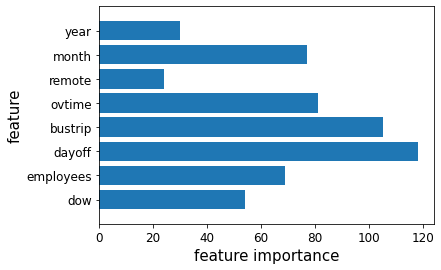

In [ ]:
plt.barh(np.arange(train_ln_X.shape[1]), best_lgbm_ln.feature_importances_, align='center')
plt.yticks(np.arange(train_ln_X.shape[1]), train_ln_X.columns)
plt.ylim(-1, train_ln_X.shape[1])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

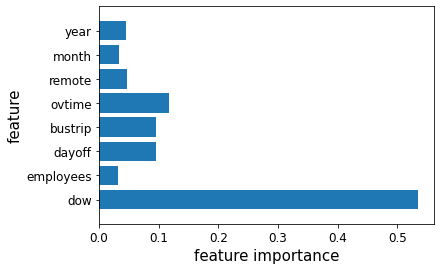

In [ ]:
plt.barh(np.arange(train_ln_X.shape[1]), best_xgb_ln.feature_importances_, align='center')
plt.yticks(np.arange(train_ln_X.shape[1]), train_ln_X.columns)
plt.ylim(-1, train_ln_X.shape[1])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

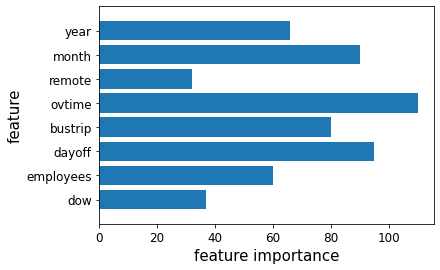

In [ ]:
plt.barh(np.arange(train_dn_X.shape[1]), best_lgbm_dn.feature_importances_, align='center')
plt.yticks(np.arange(train_dn_X.shape[1]), train_dn_X.columns)
plt.ylim(-1, train_dn_X.shape[1])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

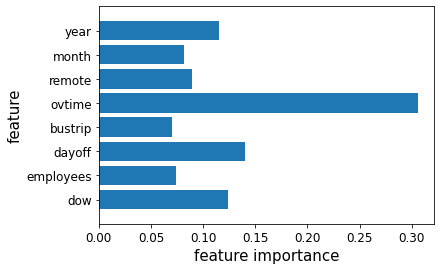

In [ ]:
plt.barh(np.arange(train_dn_X.shape[1]), best_xgb_dn.feature_importances_, align='center')
plt.yticks(np.arange(train_dn_X.shape[1]), train_dn_X.columns)
plt.ylim(-1, train_dn_X.shape[1])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [ ]:
lgbm_pred_ln = best_lgbm_ln.predict(test_ln_df)
lgbm_pred_dn = best_lgbm_dn.predict(test_dn_df)

xgb_pred_ln = best_xgb_ln.predict(test_ln_df)
xgb_pred_dn = best_xgb_dn.predict(test_dn_df)

In [ ]:
submission_xgb = submission.copy()
submission_lgbm = submission.copy()

submission_lgbm['중식계'] = lgbm_pred_ln
submission_lgbm['석식계'] = lgbm_pred_dn

submission_xgb['중식계'] = xgb_pred_ln
submission_xgb['석식계'] = xgb_pred_dn

In [ ]:
submission_xgb.head(50)

,일자,중식계,석식계
0,2021-01-27,977.663696,255.231720
1,2021-01-28,914.492432,272.266022
2,2021-01-29,634.581482,199.347717
3,2021-02-01,1187.665771,346.846191
4,2021-02-02,979.297729,322.393158
5,2021-02-03,924.925537,268.871063
6,2021-02-04,901.870667,302.925018
7,2021-02-05,654.834839,247.271652
8,2021-02-08,1227.785034,354.256989
9,2021-02-09,1005.716370,328.946777


In [ ]:
submission_lgbm.head(50)

,일자,중식계,석식계
0,2021-01-27,984.182953,385.772189
1,2021-01-28,898.853046,417.179136
2,2021-01-29,668.009824,296.580685
3,2021-02-01,1218.511026,541.767854
4,2021-02-02,1025.043594,505.833457
5,2021-02-03,981.175684,436.435283
6,2021-02-04,916.466363,480.194936
7,2021-02-05,676.893424,372.326328
8,2021-02-08,1256.712085,610.701995
9,2021-02-09,1035.376078,527.805203


In [ ]:
submission_lgbm.to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/submission_lgbm_15.csv', index=False)
submission_xgb.to_csv('/content/gdrive/My Drive/Colab Notebooks/LH/submission_xgb_15.csv', index=False)

# keras 이용

In [ ]:
# menu 빈도 이용

import tensorflow as tf
import pandas as pd


### test data 메뉴 개수

In [ ]:
test_re = pd.read_csv("test.csv")
test_re.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn']
to_datetime(test_re, 'date')

test1 = test_re.drop(['date', 'brk', 'ln', 'dn', 'employees', 'dayoff', 'bustrip', 'remote'], axis=1)

In [ ]:
ln_menu_new_test = []
for menu in test_re['ln']:
    ln_menu_new_test.append(menu.strip().split(' '))

print(ln_menu_new_test)

In [ ]:
menu_ln = []
for element in ln_menu_new_test:
    for j in element:
        menu_ln.append(j)

count_ln = {}        
for i in menu_ln:   
    try: count_ln[i] += 1
    except: count_ln[i]=1
print(count_ln)

In [ ]:
count_ln_new_test = {}
for key, value in count_ln.items():
    if key == '':
        pass
    elif '밥' in key:
        pass
    elif '김치' in key:
        pass
    elif '겉절이' in key:
        pass
    elif '깍두기' in key:
        pass
    elif key == '*':
        pass
    elif ':' in key:
        pass
    else: count_ln_new_test[key] = value
        
print(count_ln_new_test)
        

In [ ]:
dn_menu_new_test = []
for menu in test_re['dn']:
    dn_menu_new_test.append(menu.strip().split(' '))

print(dn_menu_new_test)

In [ ]:
menu_dn = []
for element in dn_menu_new_test:
    for j in element:
        menu_dn.append(j)

count_dn = {}        
for i in menu_dn:   
    try: count_dn[i] += 1
    except: count_dn[i]=1
print(count_dn)

In [ ]:
count_dn_new_test = {}
for key, value in count_dn.items():
    if key == '':
        pass
    elif '밥' in key:
        pass
    elif '김치' in key:
        pass
    elif '겉절이' in key:
        pass
    elif '깍두기' in key:
        pass
    elif key == '*':
        pass
    elif ':' in key:
        pass
    else: count_dn_new_test[key] = value
        
print(count_dn_new_test)

In [ ]:
count_ln_test = pd.DataFrame(list(count_ln_new_test.items()), columns = ['menu','counts']).sort_values(by=['counts'], axis=0, ascending=False)
count_ln_test.head()

In [ ]:
count_dn_test = pd.DataFrame(list(count_dn_new_test.items()), columns = ['menu','counts']).sort_values(by=['counts'], axis=0, ascending=False)
count_dn_test.head()

In [ ]:
test_re['ln_count'] = 0
test_re['dn_count'] = 0
for i in range(count_ln_test.shape[0]):
    for j in range(test_re.shape[0]):
        if count_ln_test['menu'][i] in test_re['ln'][j]:
            test_re['ln_count'][j] = test_re['ln_count'][j] + count_ln_test['counts'][i]

In [ ]:
for i in range(count_dn_test.shape[0]):
    for j in range(test_re.shape[0]):
        if count_dn_test['menu'][i] in test_re['dn'][j]:
            test_re['dn_count'][j] = test_re['dn_count'][j] + count_dn_test['counts'][i]

In [ ]:
test_re.head()

### keras 적용

In [ ]:
X_train = df.copy()[0:963]
X_test = df.copy()[964:].reset_index(drop=True)

train_target = X_train[['target_ln','target_dn']] 
# Y data 변수 2개

X_train.drop(['target_ln', 'target_dn', 'ln_weight', 'dn_weight', 'in_office'],axis=1, inplace=True)
X_test.drop(['target_ln', 'target_dn', 'ln_weight', 'dn_weight', 'in_office'], axis=1, inplace=True)
# X data 변수 8개

In [ ]:
X = tf.keras.layers.Input(shape=[8])
H1 = tf.keras.layers.Dense(10, activation="selu")(X)
H2 = tf.keras.layers.Dense(10, activation="selu")(H1)
Y = tf.keras.layers.Dense(2)(H2)
model = tf.keras.models.Model(X, Y)
model.compile(loss='mae',
              metrics=['mae', 'mse'])

In [ ]:
model.fit(X_train, train_target, epochs=10000, verbose=0)
model.fit(X_train, train_target, epochs=100)

# mae: 69.1

## Baseline

In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/LH/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/LH/test.csv")
submission = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/LH/sample_submission.csv")

In [ ]:
# 요일을 숫자로 매핑
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

In [ ]:
# 수치 데이터만 피처로 선택
x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [ ]:
# 점심과 저녁을 식수 인원을 예측할 2개 모델 생성
model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
# 학습
model1.fit(x_train, y1_train)
model2.fit(x_train, y2_train)

In [ ]:
# 추론
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)

In [ ]:
print('model1', MSE(y1_train, model1.predict(x_train)))
print('model2', MSE(y2_train, model2.predict(x_train)))

In [ ]:
# 결과 제출
submission['중식계'] = pred1
submission['석식계'] = pred2